In [6]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import numpy as np
import torch
import torchvision

### Create output folders

In [8]:
from pathlib import Path

Path("./Models").mkdir(parents=True, exist_ok=True)
Path("./matrices").mkdir(parents=True, exist_ok=True)
Path("./outputs").mkdir(parents=True, exist_ok=True)

## 1. Utils functions

### 1.1 Import Libraries

In [9]:
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 1.2 Function for Saving Naive Bayes and Decision Tree Models 

In [10]:
def save_model_without_pytorch(model, filename):
    path = f"./Models/{filename}"
    with open(path, 'wb') as f:
        pickle.dump(model, f)

### 1.3 Function for Loading Naive Bayes and Decision Tree Models

In [11]:
def load_model_without_pytorch(filename):
    path = f"./Models/{filename}"
    with open(path,'rb') as f:
        model = pickle.load(f)
    return model

### 1.4 Function for Evaluating Models

In [12]:
# CIFAR10 classes texted labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def evaluation(y_true, y_pred, model_name):
    y_true = [classes[i] for i in y_true]
    y_pred = [classes[i] for i in y_pred]
    # Evaluate the Model
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(f'./matrices/{model_name}_confusion_matrix.png')

    # Metrics Calculation
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Print Metrics
    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    return accuracy, precision, recall, f1

### 1.5 Function for Comparing Accuracy

In [13]:
def saveAccuracyBarPlot(models, performances, title, evaluationType):
    Path("./outputs").mkdir(parents=True, exist_ok=True)
    _, ax = plt.subplots()

    bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

    ax.bar(models, performances, label=models, color=bar_colors)

    ax.set_ylabel(evaluationType)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.legend(title='Model', loc='best')
    plt.savefig(f'./outputs/{title}.png')


### 1.6 Function for Plotting Training Losses

In [14]:

def saveTrainLossPlot(loss, modelName, step=0.3):
    plt.figure(figsize=(15,5))
    epochs = range(1, len(loss)+1)

    # Plot and label the training and validation loss values
    plt.plot(epochs, loss, label='Training Loss')

    # Add in a title and axes labels
    plt.title(f'Training Loss of {modelName}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Set the tick locations
    plt.xticks(np.arange(0, len(epochs)+1, 1))
    plt.yticks(np.arange(0, np.max(loss)+step, step))

    # Display the plot
    plt.legend(loc='best')
    plt.savefig(f'./outputs/{modelName}_Loss.png')

### 1.7 Function for Plotting Training Accuracy

In [15]:
def saveTrainAccuracyPlot(accuracy, modelName):
    Path("./outputs").mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(15,5))
    epochs = range(1, len(accuracy)+1)
    
    # Plot and label the training and validation loss values
    plt.plot(epochs, accuracy, label='Training Accuracy')

    # Add in a title and axes labels
    plt.title(f'Training Accuracy of {modelName}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Set the tick locations
    plt.xticks(np.arange(0, len(epochs)+1, 1))
    plt.yticks(np.arange(0, 101, 10))

    # Display the plot
    plt.legend(loc='best')
    plt.savefig(f'./outputs/{modelName}_accuracy.png')

### 1.8 Function for Visualizing Images

In [16]:
def imshow(img):
    # Convert image to numpy
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## 2. Dataset

### Import Libraries

In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn


### Self-defined CIFAR10 Class

In [18]:
import torchvision.transforms as transforms
import torchvision.models as pretrained_models
from sklearn.decomposition import PCA
from torchvision.models import ResNet18_Weights

class CIFAR10:
    def __init__(self):
        resnet18_model = pretrained_models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Remove the last layer
        self.resnet18 = torch.nn.Sequential(*(list(resnet18_model.children())[:-1]))
        self.resnet18.eval()

    # This method returns an array of indexes of the samples we want to include in our training/test set
    def get_n_samples_per_classes(self, limit, dataSet, numOfClasses, samplesOfClasses):
        indexes = list()
        for i, [_, label] in enumerate(dataSet):
            if samplesOfClasses[label] < limit:
                indexes.append(i)
                samplesOfClasses[label]+=1
            else:
                continue
            if samplesOfClasses[label] == limit:
                numOfClasses -=1
                # This condition is hold when we have all 'limit' samples for all classes 
                # (i.e limit = 500 samples for training and limit = 100 samples for testing)
                if numOfClasses == 0:
                    break
        return indexes
    
    def getSubset(self, limit, training=True, transforms=None):
        # Loading CIFAR10
        dataset = torchvision.datasets.CIFAR10(root='./data', train=training, download=True, transform=transforms)
        numOfClasses = 10

        # This array tracks the number of images per class collected so far.
        # We use it to terminate the process as soon as all classes have sufficient images.
        currentSamplesOfClasses = np.zeros(numOfClasses) 
        samples = self.get_n_samples_per_classes(limit,dataset,numOfClasses, currentSamplesOfClasses)
        cifar10_subset  = torch.utils.data.Subset(dataset, samples)
        return cifar10_subset
    
    def loadDataset(self, limit, training=True):
        # Tranformer to tranform images obtained from CIFAR10 
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #  The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
            #  https://pytorch.org/vision/0.8/models.html
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
        ])
    
    #print(classes[labels[0]])
        # Get CIFAR10 subset
        cifar10_subset  = self.getSubset(limit, training)

        labels = list()
        images = list()
        for img, label in cifar10_subset:
            labels.append(label)
            transformedImage = transform(img)
            # Since resnet18 expects an 4D input which correspond to (Batch x Channel x Height x Width)
            # We need to add a batch dimension
            transformedImage = transformedImage.unsqueeze(0)
            # Disable computing gradient because we are using a pretrained model
            with torch.no_grad():
                extractedImage = self.resnet18(transformedImage)
                # Reshape the resnet's output from (1, 512, 1, 1) to (1, 512)
                flatten = torch.flatten(extractedImage, start_dim = 1)
                images.append(flatten)
    
        return labels, images

## 2. Load images and process them for Naive Bayes, Decision Trees, and MLP

### Instantiate the CIFAR10 class

In [19]:
# Instantiate the CIFAR10 class for data loading and preprocessing
cifar10 = CIFAR10()

### Visualize Training Images

Files already downloaded and verified


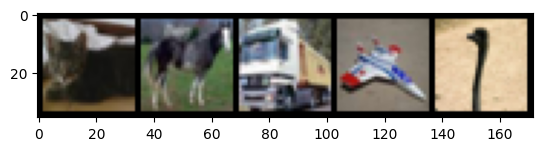

cat   horse truck plane bird 


In [20]:
# Visualize data
transform = transforms.Compose([transforms.ToTensor()])
cifar10_training_images  = cifar10.getSubset(5, transforms=transform)
trainloader = torch.utils.data.DataLoader(cifar10_training_images, batch_size=5,
                                          shuffle=True, num_workers=2)
imageIters = iter(trainloader)
images, labels = next(imageIters)

# Display images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

### Load and Process Training Images and Test Images

In [21]:
# Load and preprocess the dataset (500 training samples per class, 100 test samples per class)
train_labels, train_images = cifar10.loadDataset(500)
test_labels, test_images = cifar10.loadDataset(100, training=False)

# Part 2.3 use PCA from scikit learn
# Convert lists of tensors to NumPy arrays and reshape for PCA
train_images = np.vstack([img.numpy() for img in train_images]).reshape(-1, 512)
test_images = np.vstack([img.numpy() for img in test_images]).reshape(-1, 512)

# Apply PCA to reduce dimensionality to 50

pca = PCA(n_components=50)
train_images_reduced = pca.fit_transform(train_images)
test_images_reduced = pca.transform(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Print the result to confirm the transformation has been done correctly
print("Reduced training images shape:", train_images_reduced.shape)
print("Reduced test images shape:", test_images_reduced.shape)

Files already downloaded and verified
Files already downloaded and verified
Reduced training images shape: (5000, 50)
Reduced test images shape: (1000, 50)


## 3. Models

### Import Common Libraries

### 3.1 Naive Bayes

#### 3.1.1 Python Naive Bayes

##### Self-Defined Gaussian Naive Bayes Class

In [ ]:
class PythonGaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        # Get unique class labels and initialize parameters
        self.classes = np.unique(y)
        n_features = X.shape[1]

        # Initialize mean, variance, and prior for each class
        self.mean = np.zeros((len(self.classes), n_features), dtype=np.float64)
        self.var = np.zeros((len(self.classes), n_features), dtype=np.float64)
        self.priors = np.zeros(len(self.classes), dtype=np.float64)

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.var[idx, :] = X_c.var(axis=0)
            self.priors[idx] = X_c.shape[0] / float(X.shape[0])

    def _gaussian_density(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        y_pred = [self._predict_single(x) for x in X]
        return np.array(y_pred)

    def _predict_single(self, x):
        posteriors = []

        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            class_conditional = np.sum(np.log(self._gaussian_density(idx, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]


##### Train and Evaluate Python Gaussian Naive Bayes Model

------------------Python Gaussian Naive Bayes Model------------------
['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'dog', 'bird', 'deer', 'plane', 'truck', 'frog', 'frog', 'dog', 'deer', 'dog', 'truck', 'bird', 'deer', 'car', 'truck', 'dog', 'deer', 'frog', 'dog', 'frog', 'plane', 'truck', 'cat', 'truck', 'horse', 'frog', 'truck', 'ship', 'plane', 'cat', 'ship', 'ship', 'horse', 'horse', 'deer', 'frog', 'horse', 'cat', 'frog', 'cat', 'frog', 'bird', 'car', 'bird', 'cat', 'horse', 'bird', 'frog', 'ship', 'ship', 'plane', 'bird', 'truck', 'cat', 'cat', 'ship', 'ship', 'car', 'car', 'horse', 'bird', 'dog', 'bird', 'horse', 'ship', 'truck', 'plane', 'cat', 'ship', 'frog', 'deer', 'frog', 'frog', 'plane', 'plane', 'horse', 'deer', 'dog', 'frog', 'cat', 'car', 'car', 'cat', 'frog', 'ship', 'horse', 'deer', 'plane', 'frog', 'bird', 'car', 'cat'

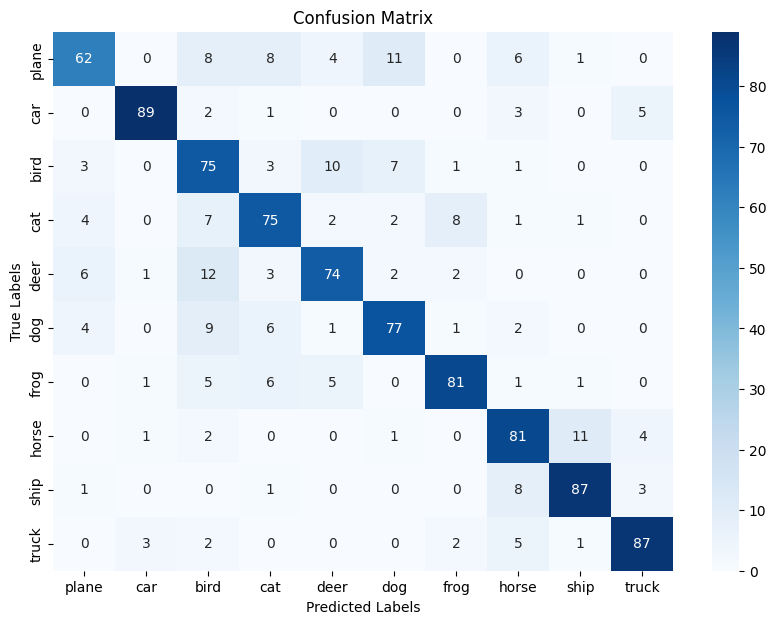

In [ ]:
# Load the trained Gaussian Naive Bayes Model if it exists
print("------------------Python Gaussian Naive Bayes Model------------------")
if os.path.exists('/model/py_GNB_model.sav'):
    py_GNB_model = load_model_without_pytorch('py_GNB_model.sav')
else:
    # Initialize and Train the customized Gaussian Naive Bayes Model
    py_GNB_model = PythonGaussianNaiveBayes()
    py_GNB_model.fit(train_images_reduced, train_labels)
    save_model_without_pytorch(py_GNB_model, 'py_GNB_model.sav')

# Make Predictions on the Test Set
y_pred = py_GNB_model.predict(test_images_reduced)
accuracy, precision, recall, f1 = evaluation(test_labels,y_pred,'py_GNB_model')

#### 3.1.2 Scikit's Gaussian Naive Bayes Model

##### Import libaries

In [ ]:
from sklearn.naive_bayes import GaussianNB

##### Train and Evaluate Scikit's Gaussian Naive Bayes Model

------------------Scikit’s Gaussian Naive Bayes Model------------------
Evaluation Metrics:
Accuracy: 78.80%
Precision: 79.30%
Recall: 78.80%
F1 Score: 78.87%


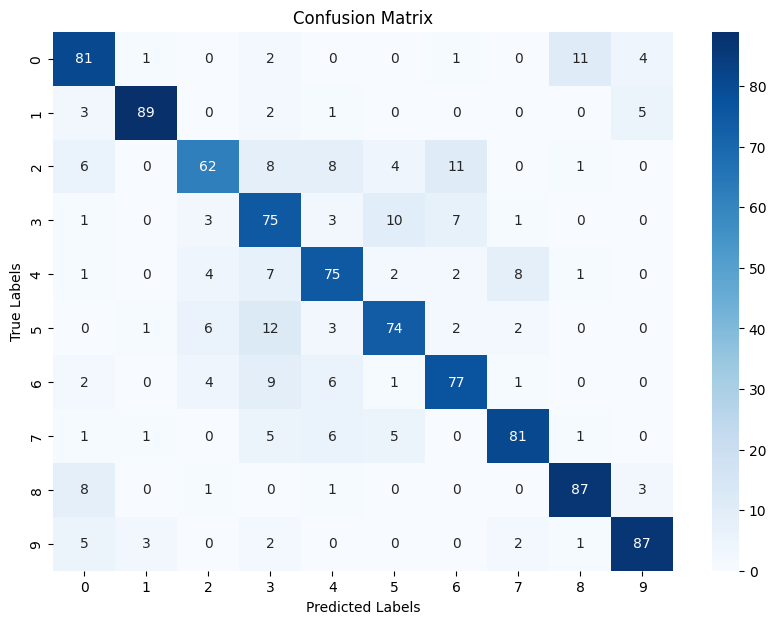

In [ ]:
# Load the trained Gaussian Naive Bayes Model if it exists
print("------------------Scikit’s Gaussian Naive Bayes Model------------------")
if os.path.exists('/model/scikit_GNB_model.sav'):
    scikit_GNB_model = load_model_without_pytorch('scikit_GNB_model.sav')
else:
    # Initialize and Train the Scikit’s Gaussian Naive Bayes Model
    scikit_GNB_model = GaussianNB()
    scikit_GNB_model.fit(train_images_reduced, train_labels)
    save_model_without_pytorch(scikit_GNB_model, 'scikit_GNB_model.sav')

# Make Predictions on the Test Set
y_pred = scikit_GNB_model.predict(test_images_reduced)
accuracy, precision, recall, f1 = evaluation(test_labels,y_pred,'scikit_GNB_model')

### 3.2 Decision Tree

#### 3.2.1 Python Decision Tree Model

##### Self-Defined Decision Tree Model

In [15]:
class TreeNode:
    def __init__(self, classifiedClass = None, featureId = None, left = None, right = None, threshold = None):
        self.classifiedClass = classifiedClass
        self.featureId = featureId
        self.left = left
        self.right = right
        self.threshold = threshold

class PythonDecisionTree:
    def __init__(self, depth):
        self.max_depth = depth
        self.root = None

    def gini(self, y):
        if (len(y) == 0):
            return None
        classes = self.groupClasses(y)/len(y)
        return np.sum(classes*(1-classes))

    def fit(self, X, y):
        self.root = self.buildDecisionTree(X, y, 0)

    def predict(self, X):
        return [self.traverseTree(self.root, x) for x in X]

    def traverseTree(self, current_root, x):
        if current_root.classifiedClass is not None:
            return current_root.classifiedClass
        index = current_root.featureId
        current_threshold = current_root.threshold
        if x[index] <= current_threshold:
            return self.traverseTree(current_root.left, x)
        else:
            return self.traverseTree(current_root.right, x)

    def buildDecisionTree(self, X, y, current_depth):
        classes = np.unique(y)
        # If we reach to the max depth or our current node is a pure leaf (containing only one class in the node)
        if  current_depth >= self.max_depth or len(classes) == 1:
            labels = self.groupClasses(y)
            return TreeNode(classifiedClass=np.argmax(labels)) # Get the dominant class
        
        # Find best feature and the best threshold for the root
        best_split_feat_id, best_split_threshold = self.findBestSplit(X, y)
        if (best_split_feat_id == None):
            labels = self.groupClasses(y)
            return TreeNode(classifiedClass=np.max(labels)) # Get the dominant class
        left_split_X, left_split_y, right_split_X, right_split_y =  self.computeSplit(X, y, best_split_feat_id, best_split_threshold)
        left_tree = self.buildDecisionTree(left_split_X, left_split_y, current_depth + 1)
        right_tree = self.buildDecisionTree(right_split_X, right_split_y, current_depth + 1)
        return TreeNode(featureId=best_split_feat_id, left=left_tree, right=right_tree,threshold=best_split_threshold)

    def groupClasses(self, y):
        classes = np.zeros(10)
        for c in y:
            classes[c] += 1
        return classes

    def findBestSplit(self, X, y):
        num_of_features = X.shape[1]
        best_id, best_threshold, best_gain = None, None, None
        for i in range(num_of_features):
            thresholds = np.unique(X[:,i])
            for th in thresholds:
                _, left_split_y, _, right_split_y =  self.computeSplit(X, y, i, th)
                gain = self.computeGain(left_split_y, right_split_y, y)
                if gain is not None and (best_gain is None or gain > best_gain):
                    best_gain = gain
                    best_id = i
                    best_threshold = th 
        return best_id, best_threshold

    def computeGain(self, left_split_y, right_split_y, root_split_y):
        parent_nodes = len(root_split_y)
        left_nodes = len(left_split_y)
        right_nodes = len(right_split_y)

        gini_left = self.gini(left_split_y)
        gini_right = self.gini(right_split_y)
        gini_parent = self.gini(root_split_y)
        if (gini_left == None or gini_right == None):
            return None
        
        return gini_parent - ((left_nodes/parent_nodes)*gini_left + (right_nodes/parent_nodes)*gini_right)

    def computeSplit(self, X, y, feature_index, threshold):
        feature_values = X[:, feature_index]
        mask = feature_values > threshold
        below_or_equal_threshold = X[~mask] # left node
        below_or_equal_threshold_classes = y[~mask]
        above_threshold = X[mask] # right node
        above_threshold_classes = y[mask]
        return below_or_equal_threshold, below_or_equal_threshold_classes, above_threshold, above_threshold_classes

##### Train and Evaluate Python Decision Tree Model

------------------Python Decision Tree Model------------------
['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'dog', 'bird', 'deer', 'plane', 'truck', 'frog', 'frog', 'dog', 'deer', 'dog', 'truck', 'bird', 'deer', 'car', 'truck', 'dog', 'deer', 'frog', 'dog', 'frog', 'plane', 'truck', 'cat', 'truck', 'horse', 'frog', 'truck', 'ship', 'plane', 'cat', 'ship', 'ship', 'horse', 'horse', 'deer', 'frog', 'horse', 'cat', 'frog', 'cat', 'frog', 'bird', 'car', 'bird', 'cat', 'horse', 'bird', 'frog', 'ship', 'ship', 'plane', 'bird', 'truck', 'cat', 'cat', 'ship', 'ship', 'car', 'car', 'horse', 'bird', 'dog', 'bird', 'horse', 'ship', 'truck', 'plane', 'cat', 'ship', 'frog', 'deer', 'frog', 'frog', 'plane', 'plane', 'horse', 'deer', 'dog', 'frog', 'cat', 'car', 'car', 'cat', 'frog', 'ship', 'horse', 'deer', 'plane', 'frog', 'bird', 'car', 'cat', 'plan

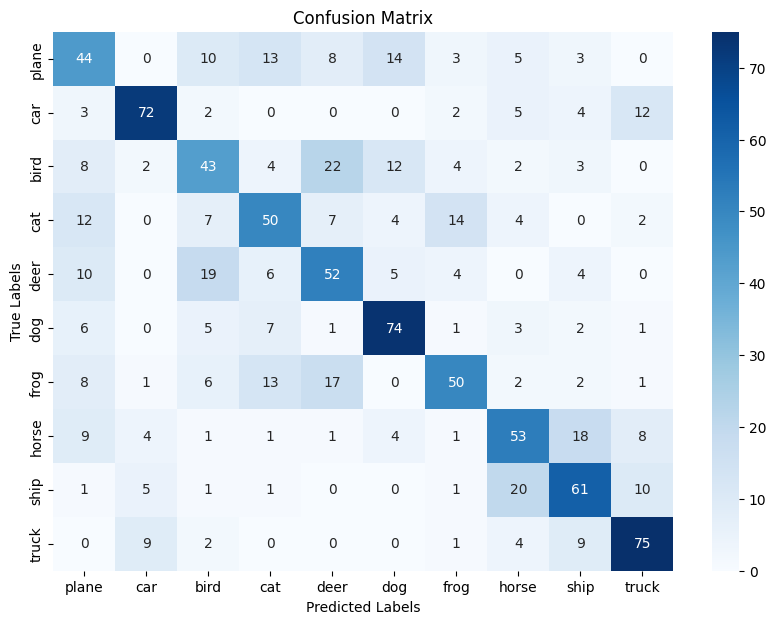

In [16]:
# Load the trained Gaussian Naive Bayes Model if it exists
print("------------------Python Decision Tree Model------------------")
if os.path.exists('./Models/dt_model.sav'):
    dt_model = load_model_without_pytorch('dt_model.sav')
else:
    #Initialize and Train the Python Decision Tree  Model
    dt_model = PythonDecisionTree(50)
    dt_model.fit(train_images_reduced,train_labels)
    dt_model_preds = dt_model.predict(test_images_reduced)
    save_model_without_pytorch(dt_model, 'dt_model.sav')

# Make Predictions on the Test Set
y_pred = dt_model.predict(test_images_reduced)
accuracy, precision, recall, f1 = evaluation(test_labels,y_pred,'dt_model')

##### Experiment by varying the depth of the tree

Decision Tree with the max depth of 5
['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'dog', 'bird', 'deer', 'plane', 'truck', 'frog', 'frog', 'dog', 'deer', 'dog', 'truck', 'bird', 'deer', 'car', 'truck', 'dog', 'deer', 'frog', 'dog', 'frog', 'plane', 'truck', 'cat', 'truck', 'horse', 'frog', 'truck', 'ship', 'plane', 'cat', 'ship', 'ship', 'horse', 'horse', 'deer', 'frog', 'horse', 'cat', 'frog', 'cat', 'frog', 'bird', 'car', 'bird', 'cat', 'horse', 'bird', 'frog', 'ship', 'ship', 'plane', 'bird', 'truck', 'cat', 'cat', 'ship', 'ship', 'car', 'car', 'horse', 'bird', 'dog', 'bird', 'horse', 'ship', 'truck', 'plane', 'cat', 'ship', 'frog', 'deer', 'frog', 'frog', 'plane', 'plane', 'horse', 'deer', 'dog', 'frog', 'cat', 'car', 'car', 'cat', 'frog', 'ship', 'horse', 'deer', 'plane', 'frog', 'bird', 'car', 'cat', 'plane', 'deer', 'bird', 'hors

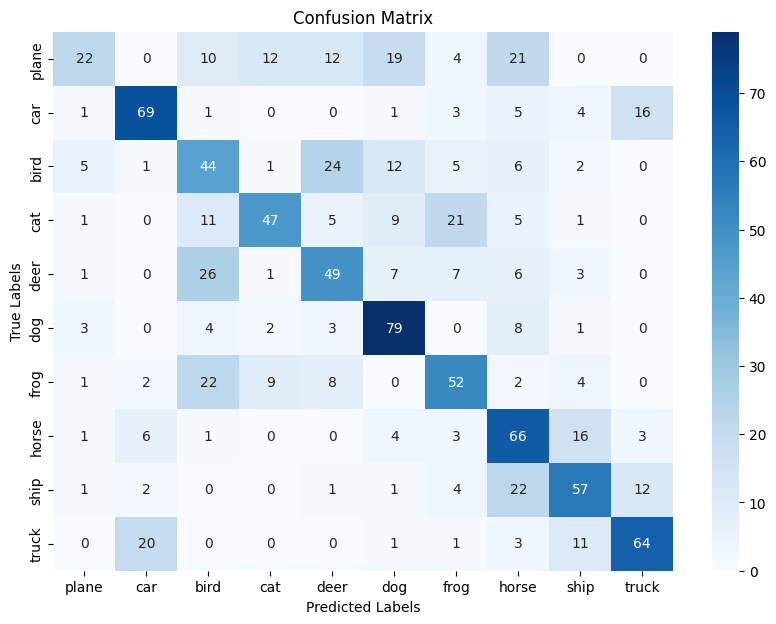

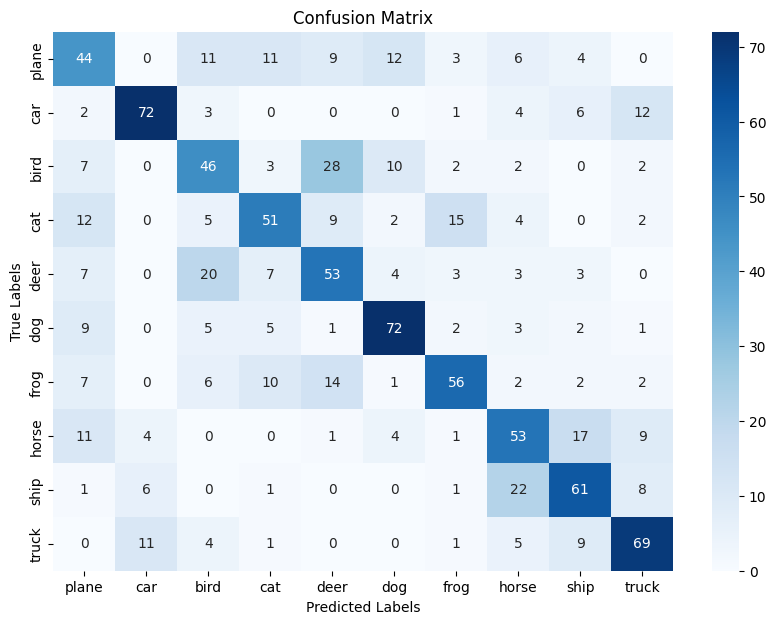

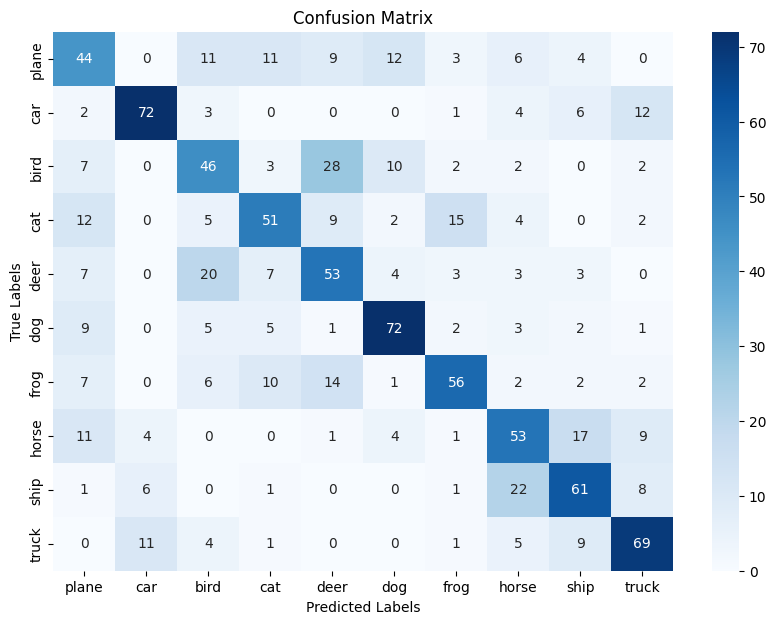

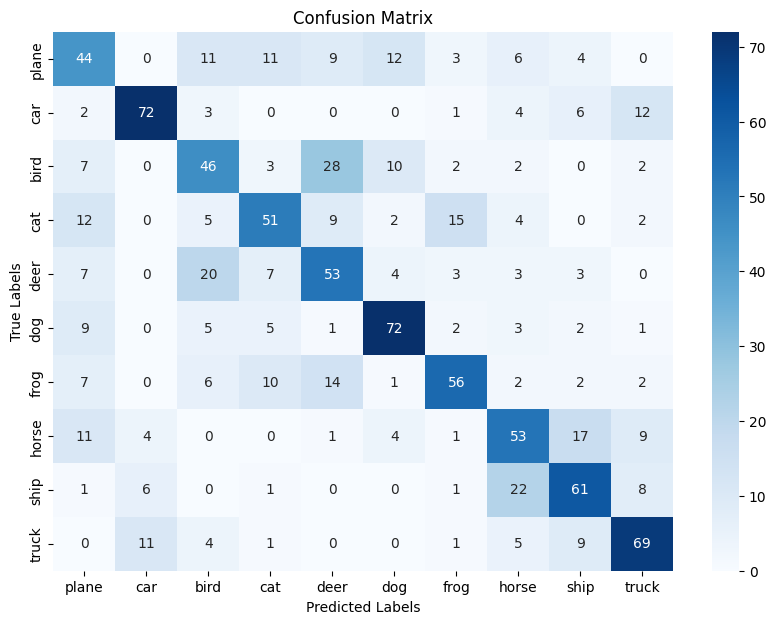

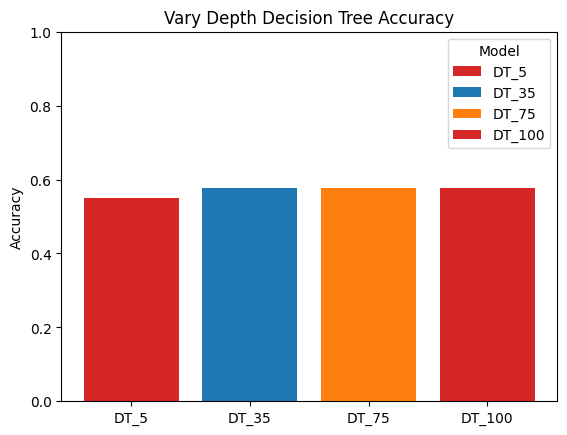

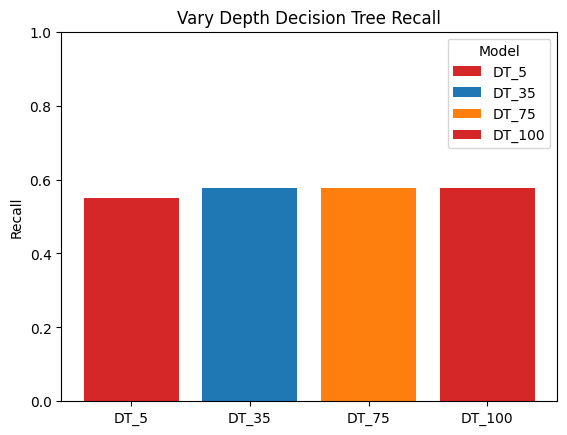

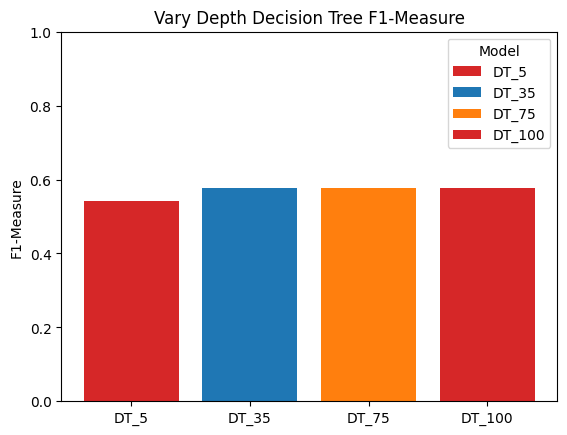

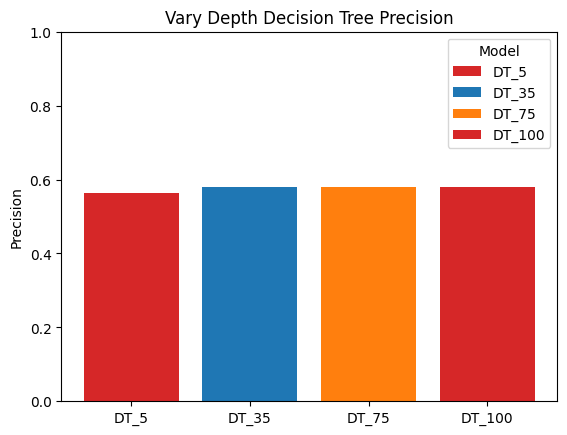

In [17]:
depths = [5, 35, 75, 100]
models = []
accuracyArray = []
recallArray = []
f1Array = []
precisionArray = []
for depth in depths:
    print(f"Decision Tree with the max depth of {depth}")
    if os.path.exists(f'./Models/dt_model_{depth}.sav'):
        exp_dt_model = load_model_without_pytorch(f'dt_model_{depth}.sav')
    else:
        #Initialize and Train the Python Decision Tree  Model
        exp_dt_model = PythonDecisionTree(depth)
        exp_dt_model.fit(train_images_reduced,train_labels)
    # Make Predictions on the Test Set
    y_pred = exp_dt_model.predict(test_images_reduced)
    accuracy, precision, recall, f1 = evaluation(test_labels,y_pred,f'dt_model_{depth}')
    models.append(f"DT_{depth}")
    accuracyArray.append(accuracy)
    recallArray.append(recall)
    precisionArray.append(precision)
    f1Array.append(f1)
saveAccuracyBarPlot(models, accuracyArray, "Vary Depth Decision Tree Accuracy", "Accuracy")
saveAccuracyBarPlot(models, recallArray, "Vary Depth Decision Tree Recall", "Recall")
saveAccuracyBarPlot(models, f1Array, "Vary Depth Decision Tree F1-Measure", "F1-Measure")
saveAccuracyBarPlot(models, precisionArray, "Vary Depth Decision Tree Precision", "Precision")

#### 3.2.2 Scikit's Decision Tree Model

##### Import Libraries

In [18]:
from sklearn.tree import DecisionTreeClassifier

##### Train and Evaluate Scikit's Decision Tree Model

------------------Scikit Decision Tree Model------------------
['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'dog', 'bird', 'deer', 'plane', 'truck', 'frog', 'frog', 'dog', 'deer', 'dog', 'truck', 'bird', 'deer', 'car', 'truck', 'dog', 'deer', 'frog', 'dog', 'frog', 'plane', 'truck', 'cat', 'truck', 'horse', 'frog', 'truck', 'ship', 'plane', 'cat', 'ship', 'ship', 'horse', 'horse', 'deer', 'frog', 'horse', 'cat', 'frog', 'cat', 'frog', 'bird', 'car', 'bird', 'cat', 'horse', 'bird', 'frog', 'ship', 'ship', 'plane', 'bird', 'truck', 'cat', 'cat', 'ship', 'ship', 'car', 'car', 'horse', 'bird', 'dog', 'bird', 'horse', 'ship', 'truck', 'plane', 'cat', 'ship', 'frog', 'deer', 'frog', 'frog', 'plane', 'plane', 'horse', 'deer', 'dog', 'frog', 'cat', 'car', 'car', 'cat', 'frog', 'ship', 'horse', 'deer', 'plane', 'frog', 'bird', 'car', 'cat', 'plan

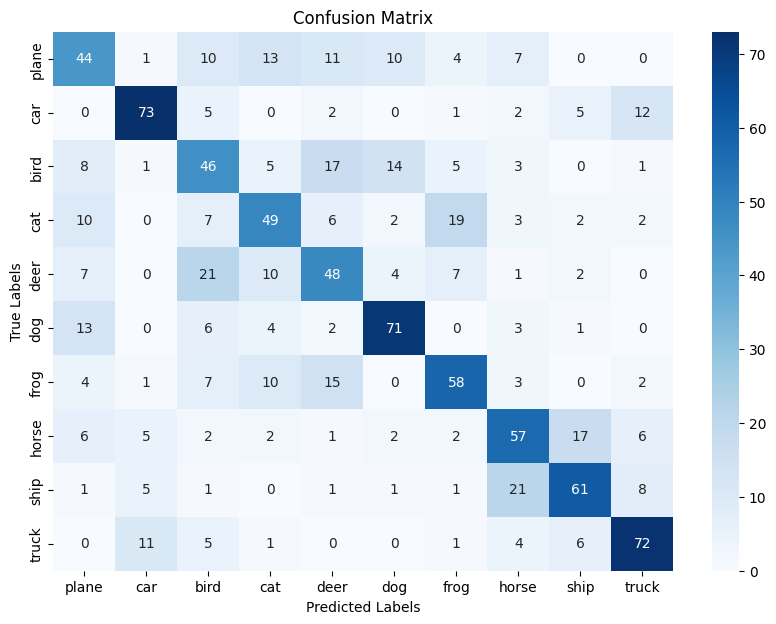

In [19]:
# Load the trained Scikit's Decision Tree Model if it exists
print("------------------Scikit Decision Tree Model------------------")
if os.path.exists('./Models/scikit_DT_model.sav'):
    scikit_DT_model = load_model_without_pytorch('scikit_DT_model.sav')
else:
    # Initialize and Train the Scikit’s Decision Tree Model
    scikit_DT_model = DecisionTreeClassifier(criterion='gini', max_depth=50,  min_samples_split=2, min_samples_leaf=1)
    scikit_DT_model.fit(train_images_reduced, train_labels)
    save_model_without_pytorch(scikit_DT_model, 'scikit_DT_model.sav')

# Make predictions on the test set
y_pred = scikit_DT_model.predict(test_images_reduced)

# Evaluate the model's performance
accuracy, precision, recall, f1 = evaluation(test_labels, y_pred, 'scikit_DT_model')

### 3.3 Multi-Layer Perceptron (MLP)

#### 3.3.1 Multiple-Layer Perceptron Model

##### Self-Defined Multiple-Layer Perceptron Model

In [19]:
# Self-defined MLP model
class PythonMultiLayerPerceptron(nn.Module):
    def __init__(self, input_size=50, hidden_size=512, output_size=10, num_hidden_layers=3):
        super(PythonMultiLayerPerceptron, self).__init__()
        layers = []

        # Input Layer
        layers.append(nn.Linear(input_size, hidden_size))       # Linear(50, 512)
        layers.append(nn.ReLU())                                # ReLU activation

        # Add hidden layers dynamically based on num_hidden_layers
        # By default, it is 3 as required in the instruction P5.1
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))  # Linear(512, 512)
            layers.append(nn.BatchNorm1d(hidden_size))          # Batch normalization
            layers.append(nn.ReLU())                            # ReLU activation

        # Output Layer
        layers.append(nn.Linear(hidden_size, output_size))      # Linear(512, 10)

        self.network = nn.Sequential(*layers)

    # Forward pass through the dynamically created network
    def forward(self, x):
        return self.network(x)

##### Import Libraries

In [20]:
import torch.optim as optim

##### Train Multiple-Layer Perceptron Model

##### Implement a function to train MLP model

In [21]:
# Functions used to train python MLP model
# Training the MLP model
def train_mlp_model(model, dataloader, optimizer, criterion, device): # By default, we do 10 epochs
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()               # Set the gradient buffers to 0
        outputs = model(inputs)             # Forward pass
        loss = criterion(outputs, labels)   # Compute loss
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds==labels).sum().item() # Correct predictions
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights
        running_loss += loss.item()
        total += outputs.size(0)
    loss = running_loss/len(dataloader)
    accuracy = 100.0*(running_correct/total)
    return loss, accuracy


##### Define the batch size and the number of epochs for MLP

In [22]:
MLP_BATCH_SIZE = 32
MLP_EPOCHS = 10

##### Create a dataloader for MLP

In [23]:
dataset = torch.utils.data.TensorDataset(
                torch.tensor(train_images_reduced, dtype=torch.float32),
                torch.tensor(train_labels, dtype=torch.long)
            )
dataloader = torch.utils.data.DataLoader(dataset, batch_size=MLP_BATCH_SIZE, shuffle=True)

In [ ]:
# Load the trained Python Multiple-Layer Perceptron Model if it exists
print("------------------Python Multiple-Layer Perceptron Tree Model------------------")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Initialize the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss function
py_MLP_model = PythonMultiLayerPerceptron()
py_MLP_model = nn.DataParallel(py_MLP_model)
py_MLP_model.to(device)
if os.path.exists('./Models/py_MLP_model.pth'):
    print("------------------Python Multi-Layer Perceptron Model------------------")
    py_MLP_model.load_state_dict(torch.load('./Models/py_MLP_model.pth'))
else:
    # Initialize the MLP model
    optimizer = optim.SGD(py_MLP_model.parameters(), lr=0.01, momentum=0.9) # SGD optimizer with momentum = 0.9
    trainingLoss = []
    trainningAccuracy = []
    BestACC = 0
    for epoch in range(MLP_EPOCHS):
    # Start training the customized MLP model
        train_loss, train_accuraccy = train_mlp_model(py_MLP_model, dataloader, optimizer, criterion, device)
        trainingLoss.append(train_loss)
        trainningAccuracy.append(train_accuraccy)
        print(f"Epoch {epoch+1}/{MLP_EPOCHS}, Loss: {train_loss:.4f}")
    # Save the trained MLP model
    if train_accuraccy > BestACC:
            BestACC=train_accuraccy
            torch.save(py_MLP_model.state_dict(), './Models/py_MLP_model.pth')
    saveTrainLossPlot(trainingLoss,f'MLP')
    saveTrainAccuracyPlot(trainningAccuracy,f'MLP')

------------------Python Multiple-Layer Perceptron Tree Model------------------
------------------Python Multi-Layer Perceptron Model------------------


C:\Users\yihua\AppData\Local\Temp\ipykernel_25672\2797591106.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  py_MLP_model.load_state_dict(torch.load('./Models/py_MLP_mo

##### Evaluate Multiple-Layer Perceptron Model

In [25]:
def evaluationMLP(model, test_inputs, test_labels, num_hidden_layer=None, hidden_size=None):
    # Set the model to evaluation mode
    model.eval()  
    with torch.no_grad():
        # Convert inputs to tensor
        test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
        # Get model predictions
        test_outputs = model(test_inputs)
        test_predictions = torch.argmax(test_outputs, dim=1).numpy()

    # Create a dynamic name for the model based on its configuration
    if num_hidden_layer is not None and hidden_size is not None:
        model_name = f"py_MLP_model_depth_{num_hidden_layer}_hidden_size_{hidden_size}"
    elif num_hidden_layer is not None:
        model_name = f"py_MLP_model_depth_{num_hidden_layer}"
    elif hidden_size is not None:
        model_name = f"py_MLP_model_hidden_size_{hidden_size}"
    else:
        model_name = "py_MLP_model"

    # Save the confusion matrix dynamically
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.savefig(f"{model_name}_confusion_matrix.png")  # Save with dynamic name
    plt.close()

    # Evaluate and save the metrics
    return evaluation(test_labels, test_predictions, model_name)

Evaluation Metrics:
Accuracy: 80.30%
Precision: 80.42%
Recall: 80.30%
F1 Score: 80.22%


(0.803,
 np.float64(0.8041817891502694),
 np.float64(0.8029999999999999),
 np.float64(0.8022273119752021))

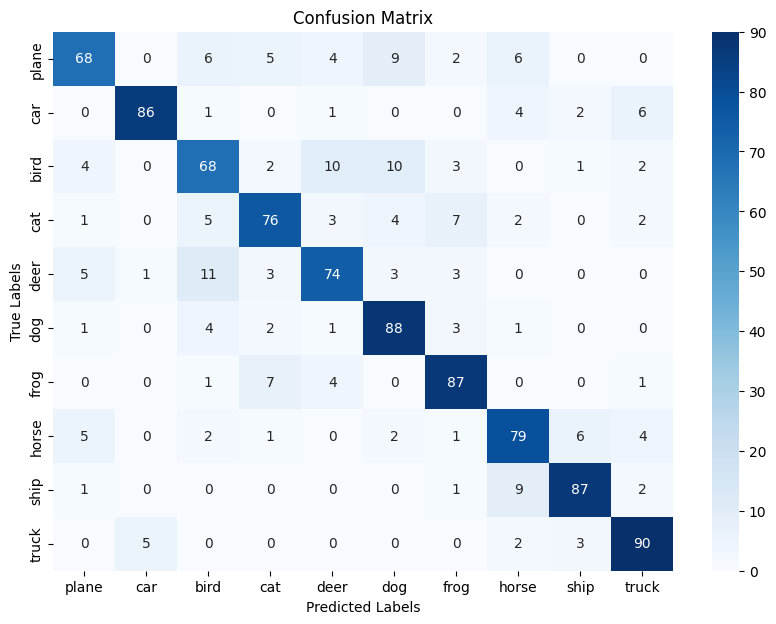

In [26]:
evaluationMLP(py_MLP_model, test_images_reduced, test_labels, num_hidden_layer=2, hidden_size=512)

#### 3.3.2 Experiment by varying the depth of the network by adding or removing layers

------------------Experimenting with python MLP 1 Hidden Layers------------------
py_MLP_model_depth_1
DataParallel(
  (module): PythonMultiLayerPerceptron(
    (network): Sequential(
      (0): Linear(in_features=50, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=10, bias=True)
    )
  )
)
Loaded trained model: py_MLP_model_depth_1


C:\Users\yihua\AppData\Local\Temp\ipykernel_25672\3352498144.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  py_MLP_layers_model.load_state_dict(torch.load(model_path))

Evaluation Metrics:
Accuracy: 82.00%
Precision: 82.24%
Recall: 82.00%
F1 Score: 82.00%
------------------Experimenting with python MLP 3 Hidden Layers------------------
py_MLP_model_depth_3
DataParallel(
  (module): PythonMultiLayerPerceptron(
    (network): Sequential(
      (0): Linear(in_features=50, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Linear(in_features=512, out_features=512, bias=True)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Linear(in_features=512, out_features=10, bias=True)
    )
  )
)
Loaded trained model: py_MLP_model_depth_3


C:\Users\yihua\AppData\Local\Temp\ipykernel_25672\3352498144.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  py_MLP_layers_model.load_state_dict(torch.load(model_path))

Evaluation Metrics:
Accuracy: 80.10%
Precision: 80.51%
Recall: 80.10%
F1 Score: 80.04%
------------------Experimenting with python MLP 5 Hidden Layers------------------
py_MLP_model_depth_5
DataParallel(
  (module): PythonMultiLayerPerceptron(
    (network): Sequential(
      (0): Linear(in_features=50, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Linear(in_features=512, out_features=512, bias=True)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Linear(in_features=512, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Linear(in_features=512, out_features=512, bias=True)
      (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine

C:\Users\yihua\AppData\Local\Temp\ipykernel_25672\3352498144.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  py_MLP_layers_model.load_state_dict(torch.load(model_path))

Evaluation Metrics:
Accuracy: 80.20%
Precision: 80.49%
Recall: 80.20%
F1 Score: 80.13%
------------------Experimenting with python MLP 7 Hidden Layers------------------
py_MLP_model_depth_7
DataParallel(
  (module): PythonMultiLayerPerceptron(
    (network): Sequential(
      (0): Linear(in_features=50, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Linear(in_features=512, out_features=512, bias=True)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Linear(in_features=512, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Linear(in_features=512, out_features=512, bias=True)
      (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine

C:\Users\yihua\AppData\Local\Temp\ipykernel_25672\3352498144.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  py_MLP_layers_model.load_state_dict(torch.load(model_path))

Evaluation Metrics:
Accuracy: 77.60%
Precision: 78.20%
Recall: 77.60%
F1 Score: 77.61%


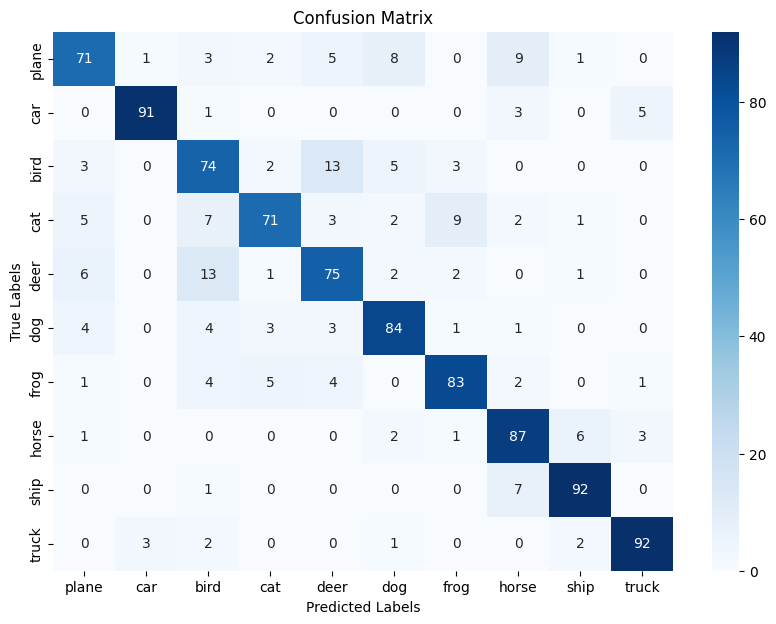

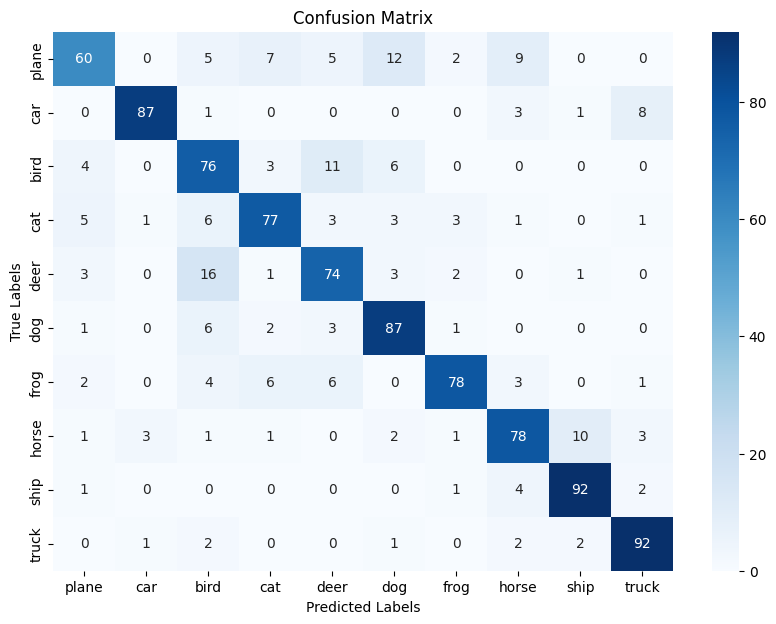

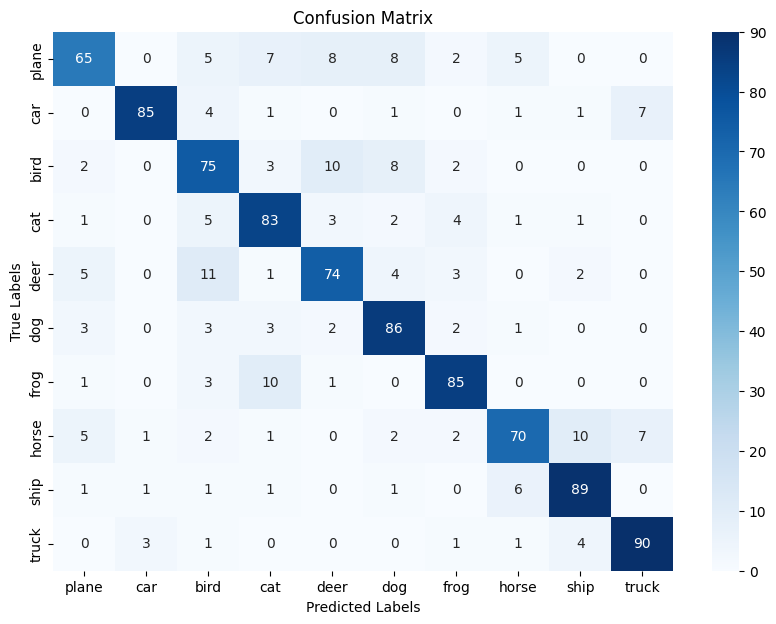

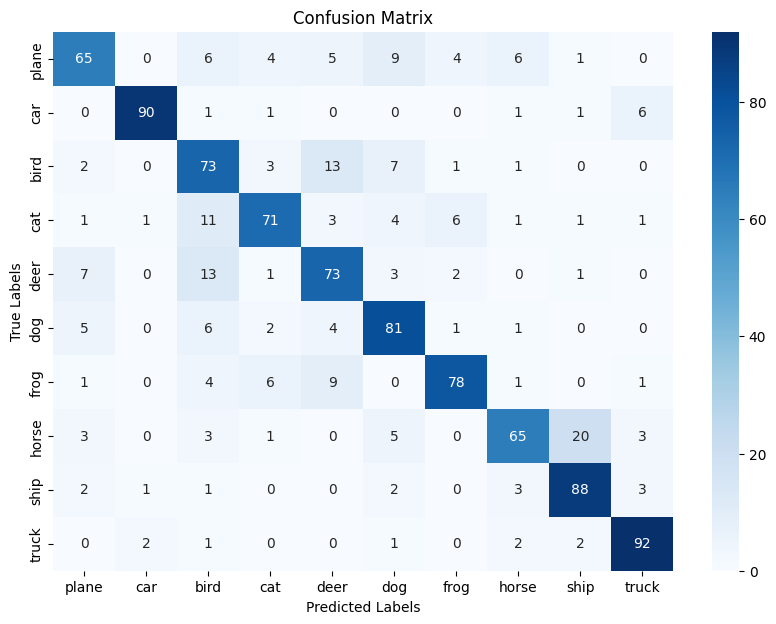

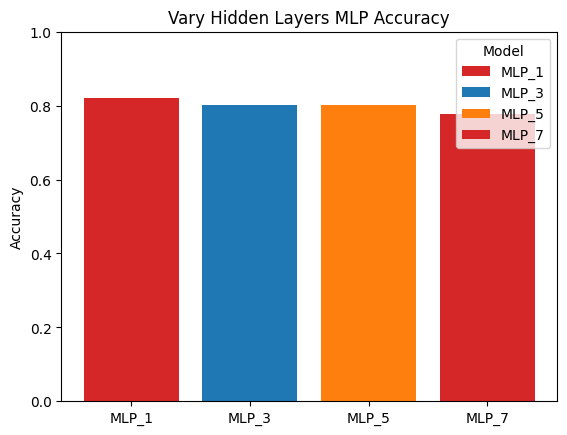

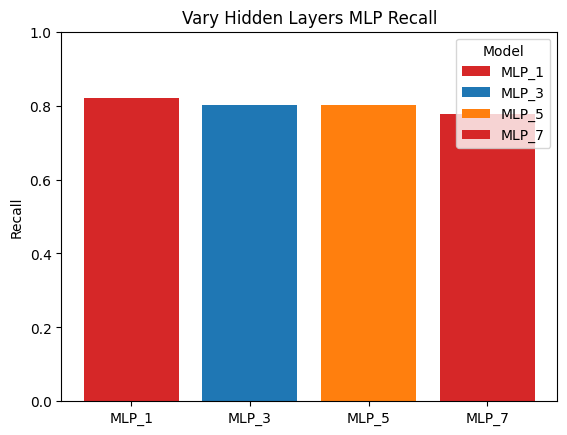

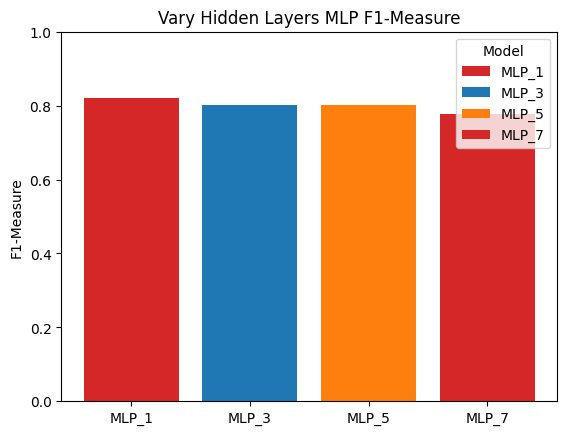

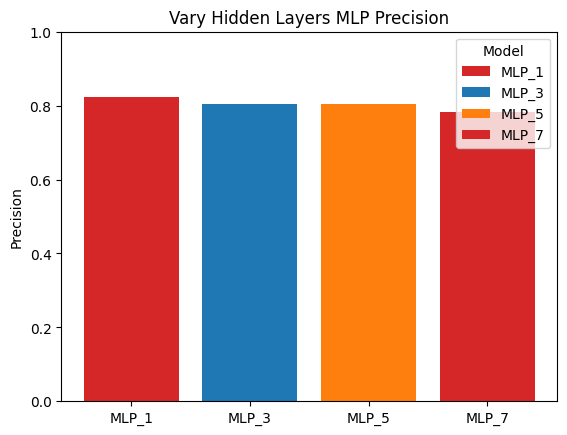

In [ ]:
depths = [1, 3, 5, 7]  # Define of hidden layers to use
models = []
accuracyArray = []
recallArray = []
precisionArray = []
f1Array = []
for num_hidden_layer in depths:
    print(f"------------------Experimenting with python MLP {num_hidden_layer} Hidden Layers------------------")
    model_name = f'py_MLP_model_depth_{num_hidden_layer}'
    model_path = f'./Models/{model_name}.pth'
    py_MLP_layers_model = PythonMultiLayerPerceptron(input_size=50, hidden_size=512, output_size=10, num_hidden_layers=num_hidden_layer)
    py_MLP_layers_model = nn.DataParallel(py_MLP_layers_model)
    py_MLP_layers_model.to(device)
    print(model_name)
    print(py_MLP_layers_model)
    if os.path.exists(model_path):
        py_MLP_layers_model.load_state_dict(torch.load(model_path))
        print(f"Loaded trained model: {model_name}")
    else:
        # Initialize the MLP layers model with the specified depth
        optimizer = optim.SGD(py_MLP_layers_model.parameters(), lr=0.01, momentum=0.9)  # SGD optimizer
        trainingLoss = []
        trainningAccuracy = []
        BEST_ACC = 0
        for epoch in range(MLP_EPOCHS):
        # Start training the customized MLP model
            train_loss, train_accuraccy = train_mlp_model(py_MLP_layers_model, dataloader, optimizer, criterion, device)
            trainingLoss.append(train_loss)
            trainningAccuracy.append(train_accuraccy)
            print(f"Epoch {epoch+1}/{MLP_EPOCHS}, Loss: {train_loss:.4f}")
        # Save the trained MLP model
            if train_accuraccy > BEST_ACC:
                BEST_ACC=train_accuraccy
                torch.save(py_MLP_layers_model.state_dict(), model_path)
        saveTrainLossPlot(trainingLoss,f'MLP_{num_hidden_layer}')
        saveTrainAccuracyPlot(trainningAccuracy,f'MLP_{num_hidden_layer}')
        print(f'MLP_{num_hidden_layer}: ', trainingLoss)
    accuracy, precision, recall, f1 = evaluationMLP(py_MLP_layers_model, test_images_reduced,test_labels, num_hidden_layer=num_hidden_layer,hidden_size=512)
    models.append(f'MLP_{num_hidden_layer}')
    accuracyArray.append(accuracy)
    recallArray.append(recall)
    precisionArray.append(precision)
    f1Array.append(f1)
saveAccuracyBarPlot(models, accuracyArray, "Vary Hidden Layers MLP Accuracy", "Accuracy")
saveAccuracyBarPlot(models, recallArray, "Vary Hidden Layers MLP Recall", "Recall")
saveAccuracyBarPlot(models, f1Array, "Vary Hidden Layers MLP F1-Measure", "F1-Measure")
saveAccuracyBarPlot(models, precisionArray, "Vary Hidden Layers MLP Precision", "Precision")

#### 3.3.3 Vary the sizes of the hidden layers.

------------------Experimenting with python MLP with Hidden Size 16------------------
Loaded trained model: py_MLP_model_hidden_size_16


C:\Users\yihua\AppData\Local\Temp\ipykernel_28584\772428762.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  py_MLP_hidden_size_model.load_state_dict(torch.load(model_pa

Evaluation Metrics:
Accuracy: 77.90%
Precision: 78.40%
Recall: 77.90%
F1 Score: 77.87%
------------------Experimenting with python MLP with Hidden Size 128------------------
Loaded trained model: py_MLP_model_hidden_size_128


C:\Users\yihua\AppData\Local\Temp\ipykernel_28584\772428762.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  py_MLP_hidden_size_model.load_state_dict(torch.load(model_pa

Evaluation Metrics:
Accuracy: 77.90%
Precision: 78.40%
Recall: 77.90%
F1 Score: 77.87%
------------------Experimenting with python MLP with Hidden Size 1024------------------
Loaded trained model: py_MLP_model_hidden_size_1024


C:\Users\yihua\AppData\Local\Temp\ipykernel_28584\772428762.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  py_MLP_hidden_size_model.load_state_dict(torch.load(model_pa

Evaluation Metrics:
Accuracy: 77.90%
Precision: 78.40%
Recall: 77.90%
F1 Score: 77.87%


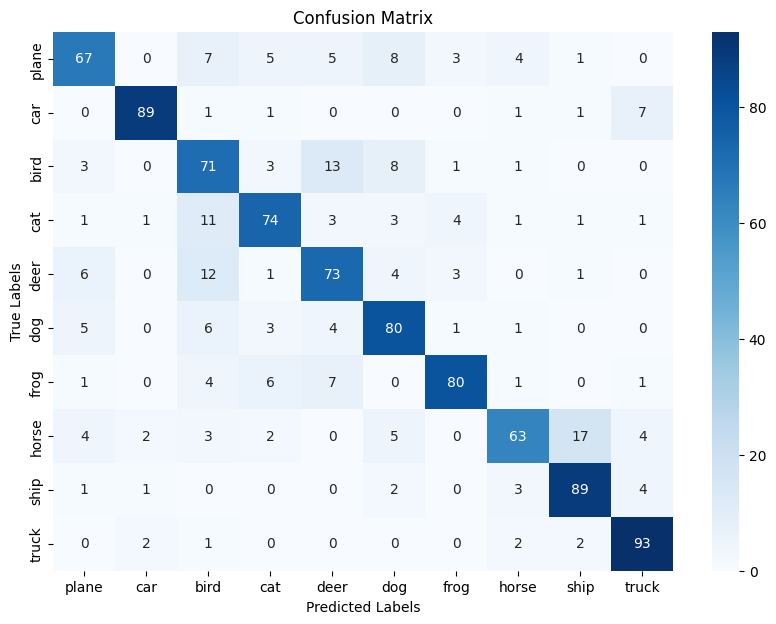

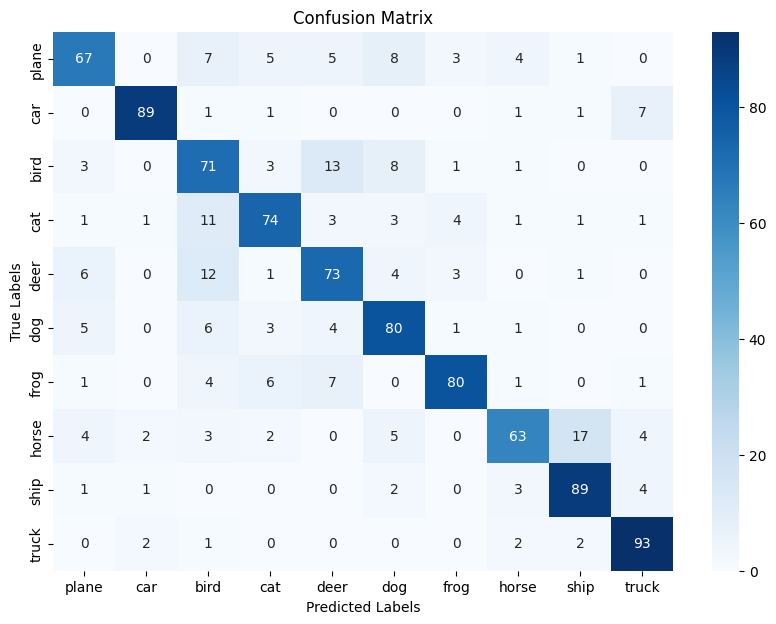

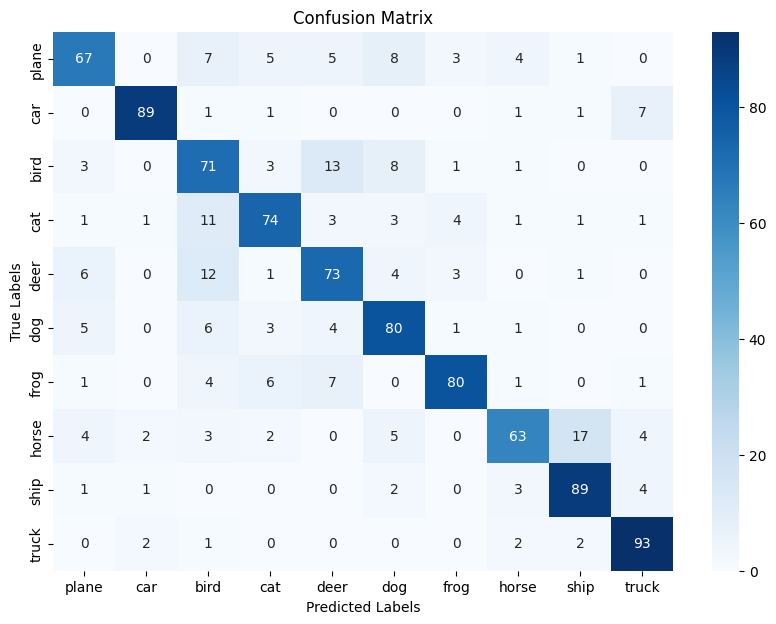

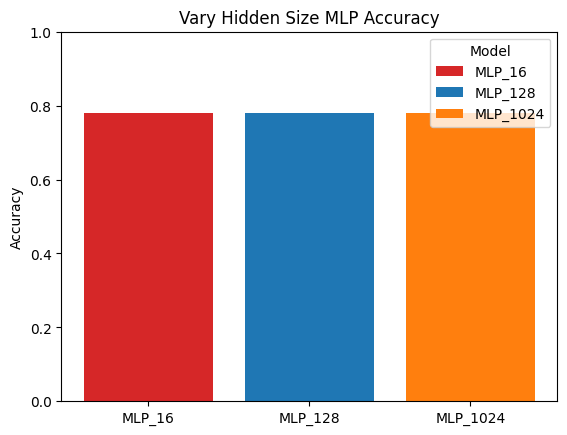

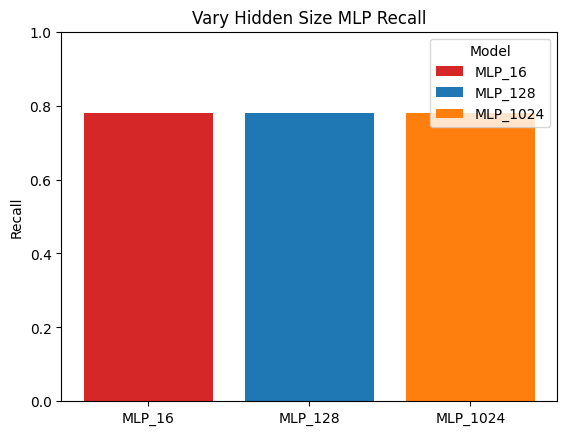

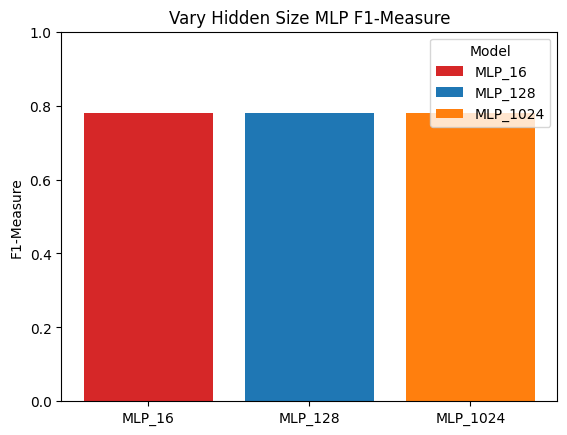

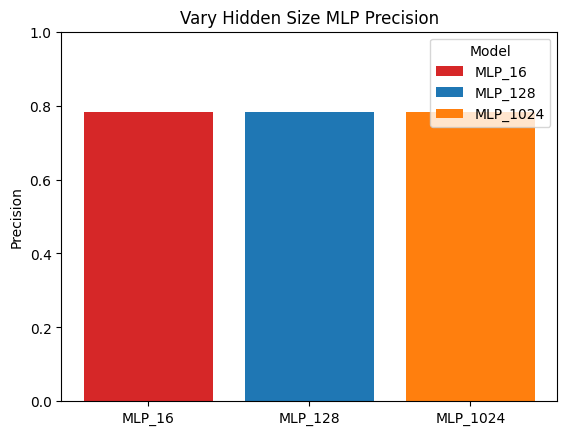

In [ ]:
hidden_layer_sizes = [16, 128, 1024]  # Define of hidden layers to use
models = []
accuracyArray = []
recallArray = []
precisionArray = []
f1Array = []
for size in hidden_layer_sizes:
    print(f"------------------Experimenting with python MLP with Hidden Size {size}------------------")
    model_name = f'py_MLP_model_hidden_size_{size}'
    model_path = f'./Models/{model_name}.pth'
    py_MLP_hidden_size_model = PythonMultiLayerPerceptron(input_size=50, hidden_size=size, output_size=10)
    py_MLP_hidden_size_model = nn.DataParallel(py_MLP_hidden_size_model)
    py_MLP_hidden_size_model.to(device)
    if os.path.exists(model_path):
        py_MLP_hidden_size_model.load_state_dict(torch.load(model_path))
        print(f"Loaded trained model: {model_name}")
    else:
        # Initialize the MLP layers model with the specified depth
        optimizer = optim.SGD(py_MLP_hidden_size_model.parameters(), lr=0.01, momentum=0.9)  # SGD optimizer
        trainingLoss = []
        trainningAccuracy = []
        BEST_ACC = 0
        for epoch in range(MLP_EPOCHS):
        # Start training the customized MLP model
            train_loss, train_accuraccy = train_mlp_model(py_MLP_hidden_size_model, dataloader, optimizer, criterion, device)
            trainingLoss.append(train_loss)
            trainningAccuracy.append(train_accuraccy)
            print(f"Epoch {epoch+1}/{MLP_EPOCHS}, Loss: {train_loss:.4f}")
            print(train_accuraccy)
        # Save the trained MLP model
            if train_accuraccy > BEST_ACC:
                Best_ACC=train_accuraccy
                torch.save(py_MLP_hidden_size_model.state_dict(), model_path)
        saveTrainLossPlot(trainingLoss,f'MLP_{size}')
        saveTrainAccuracyPlot(trainningAccuracy,f'MLP_{size}')
    accuracy, precision, recall, f1 = evaluationMLP(py_MLP_layers_model, test_images_reduced,test_labels, num_hidden_layer=2,hidden_size=size)
    models.append(f'MLP_{size}')
    accuracyArray.append(accuracy)
    recallArray.append(recall)
    precisionArray.append(precision)
    f1Array.append(f1)
saveAccuracyBarPlot(models, accuracyArray, "Vary Hidden Size MLP Accuracy", "Accuracy")
saveAccuracyBarPlot(models, recallArray, "Vary Hidden Size MLP Recall", "Recall")
saveAccuracyBarPlot(models, f1Array, "Vary Hidden Size MLP F1-Measure", "F1-Measure")
saveAccuracyBarPlot(models, precisionArray, "Vary Hidden Size MLP Precision", "Precision")

### 3.4 Convolutional Neural Network

#### 3.4.1 Convolutional Neural Network Model

##### Self-Defined Convolutional Neural Network Model

In [34]:
class CNN(torch.nn.Module):
    def __init__(self, kernel_size=3, pool_kernel_size=2, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=padding), # L1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size,stride=2),
            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=padding), # L2
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size,stride=2),
            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=padding), # L3
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=kernel_size, stride=1, padding=padding), # L4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size,stride=2),
            nn.Conv2d(256, 512, kernel_size=kernel_size, stride=1, padding=padding), # L5
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=padding), # L6
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size,stride=2),
            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=padding), # L7
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=padding), # L8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size,stride=2),
        )
        self.flatten = nn.Flatten(1)
        dummyConvOutput = torch.ones((1,) + tuple([3,32,32]))
        flatten_output_size = self.calculate_flatten(self.conv(dummyConvOutput))
        self.fc = nn.Sequential(            
            nn.Linear(flatten_output_size, 4096), # L9
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), # L10
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10) # L11)
        )
    
    def calculate_flatten(self,input):
        #Get all dimensions except batch size 
        inputDims = input.size()[1:] 
        outputSize = 1
        for d in inputDims:
            outputSize *= d
        return outputSize
    
    def forward(self, x):
        out = self.conv(x)
        out = self.flatten(out)
        out = self.fc(out)
        return out

##### Implement a function to train CNN model

In [35]:
def train(train_loader, model, device, criterion, optimizer, modelName):
    model.train()
    print(f'Training {modelName}')
    running_loss = 0.0
    running_correct = 0
    total = 0
    for _,(images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        _, preds = torch.max(output.data, 1)
        running_correct += (preds==labels).sum().item()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total += output.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * (running_correct / total)
    print("Training Loss: ",epoch_loss)
    print("Training Accuracy: ", epoch_acc)
    return epoch_loss, epoch_acc

##### Implement a function for CNN model's predictions

In [36]:
def predict(test_loader, model, device):
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for _, (images, _) in enumerate(test_loader):
            images = images.to(device)
            output = model(images)
            _, preds = torch.max(output.data, 1)
            test_predictions += preds
    return test_predictions

##### Import Library

In [37]:
from torch import optim

##### Define the batch size and the number of epochs for the CNN model

In [38]:
CNN_BATCH_SIZE = 64
CNN_EPOCHS = 30

##### Load dataset for the CNN model

In [39]:
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = CIFAR10()
train_loader =  torch.utils.data.DataLoader(cifar10.getSubset(500, transforms=transform), batch_size=CNN_BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10.getSubset(100, training=False, transforms=transform), batch_size=CNN_BATCH_SIZE, shuffle=False)
test_labels = []
for _, label in enumerate(test_loader):
    test_labels += label[1]

Files already downloaded and verified
Files already downloaded and verified


##### Train Convolution Neural Network Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN()
model = nn.DataParallel(model)
model.to(device)
training_losses, trainningAccuracy = [], []
print(model)

if os.path.exists('./Models/CNN.pth'):
    model.load_state_dict(torch.load('./Models/CNN.pth'))
    
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
    Best_ACC=0
    for epoch in range(CNN_EPOCHS):
        train_loss, train_acc = train(train_loader, model, device, criterion, optimizer, 'CNN')
        training_losses.append(train_loss)
        trainningAccuracy.append(train_acc)
        if train_acc>Best_ACC:
            Best_ACC=train_acc
            torch.save(model.state_dict(), './Models/CNN.pth')
    saveTrainLossPlot(training_losses,'CNN', 0.005)
    saveTrainAccuracyPlot(trainningAccuracy,'CNN')

DataParallel(
  (module): CNN(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU()
      (14): MaxPoo

C:\Users\yihua\AppData\Local\Temp\ipykernel_30948\351911271.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./Models/CNN.pth'))


##### Evaluate CNN Model

Evaluation Metrics:
Accuracy: 64.00%
Precision: 63.55%
Recall: 64.00%
F1 Score: 63.50%


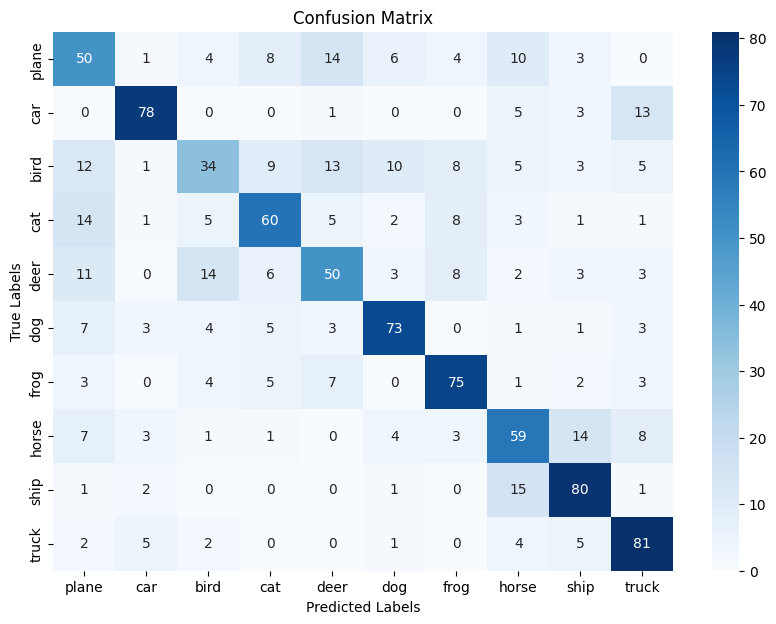

In [46]:
preds = predict(test_loader, model, device)
accuracy, precision, recall, f1 = evaluation(test_labels,preds,'CNN_model')

#### 3.4.2 Experiment by Adding or Removing Convolutional Layers 

##### Self-Defined Dynamic Layer Convolutional Network

In [29]:
class Dynamic_Layer_CNN(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        out = self.model(x)
        return out

##### Create CNN models with different layers

In [30]:
model_4_layers =nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # L1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # output's shape:[256, 64, 16, 16]
            nn.Flatten(1),
            nn.Linear(64 * 16 * 16, 4096), # L2
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), # L3
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10) # L4
        )
model_6_layers =nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # L1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # L2
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # L3
            nn.BatchNorm2d(256),
            nn.ReLU(), # output's shape:[256, 64, 16, 16]
            nn.Flatten(1),
            nn.Linear(64*16*16, 4096), # L4
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), # L5
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10) # L6
        )
model_9_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # L1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # L2
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # L3
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # L4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # L5
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # L6
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # output's shape:[256, 512, 2, 2]
            nn.Flatten(1),
            nn.Linear(512*2*2, 4096), # L7
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), # L8
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10) # L9
        )
model_12_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # L1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # L2
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # L3
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # L4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # L5
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # L6
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # L7
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # L8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # L9
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(512, 4096), # L10
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), # L11
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10) # L12
        )
model_13_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # L1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # L2
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # L3
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # L4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # L5
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # L6
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # L7
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # L8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # L9
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # L10
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2, padding=1),
            nn.Flatten(1),
            nn.Linear(512, 4096), # L11
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), # L12
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10) # L13
        )

##### Train and Evaluate Convolution Network Models with Different Layers

CNN_4_layer


C:\Users\yihua\AppData\Local\Temp\ipykernel_30948\2636601495.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  currentModel.load_state_dict(torch.load(f'./Models/{model_n

Evaluation Metrics:
Accuracy: 57.00%
Precision: 56.92%
Recall: 57.00%
F1 Score: 56.06%
CNN_6_layer


C:\Users\yihua\AppData\Local\Temp\ipykernel_30948\2636601495.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  currentModel.load_state_dict(torch.load(f'./Models/{model_n

Evaluation Metrics:
Accuracy: 62.80%
Precision: 62.75%
Recall: 62.80%
F1 Score: 62.16%
CNN_9_layer


C:\Users\yihua\AppData\Local\Temp\ipykernel_30948\2636601495.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  currentModel.load_state_dict(torch.load(f'./Models/{model_n

Evaluation Metrics:
Accuracy: 54.50%
Precision: 60.53%
Recall: 54.50%
F1 Score: 53.11%
CNN_12_layer


C:\Users\yihua\AppData\Local\Temp\ipykernel_30948\2636601495.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  currentModel.load_state_dict(torch.load(f'./Models/{model_n

Evaluation Metrics:
Accuracy: 56.50%
Precision: 61.71%
Recall: 56.50%
F1 Score: 57.02%
CNN_13_layer


C:\Users\yihua\AppData\Local\Temp\ipykernel_30948\2636601495.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  currentModel.load_state_dict(torch.load(f'./Models/{model_n

Evaluation Metrics:
Accuracy: 54.30%
Precision: 60.22%
Recall: 54.30%
F1 Score: 54.79%


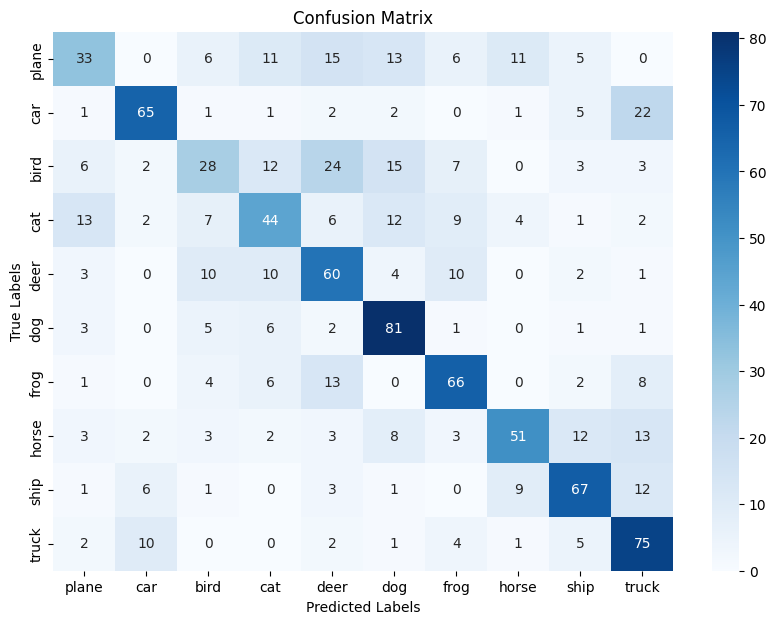

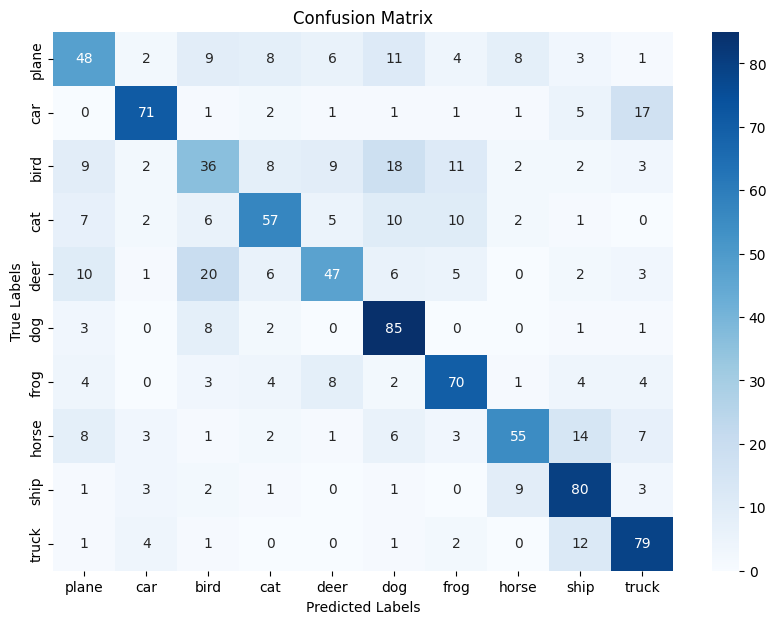

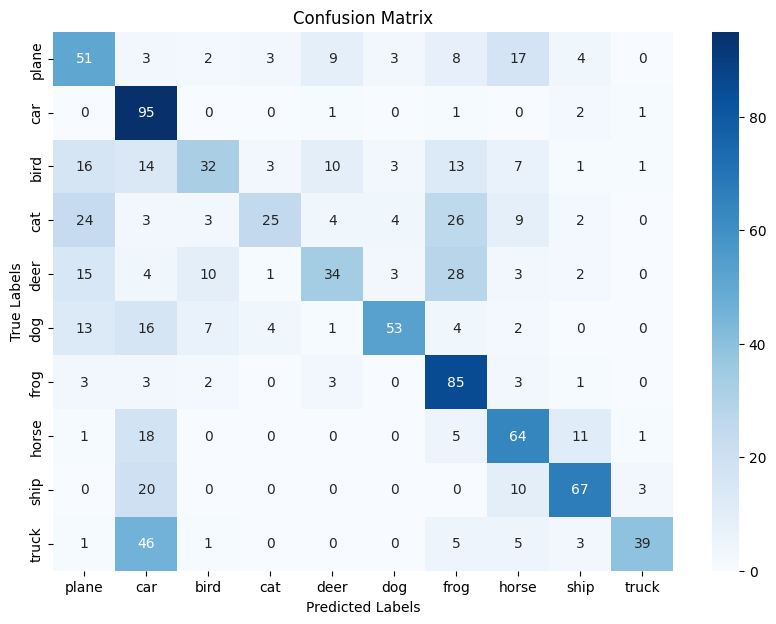

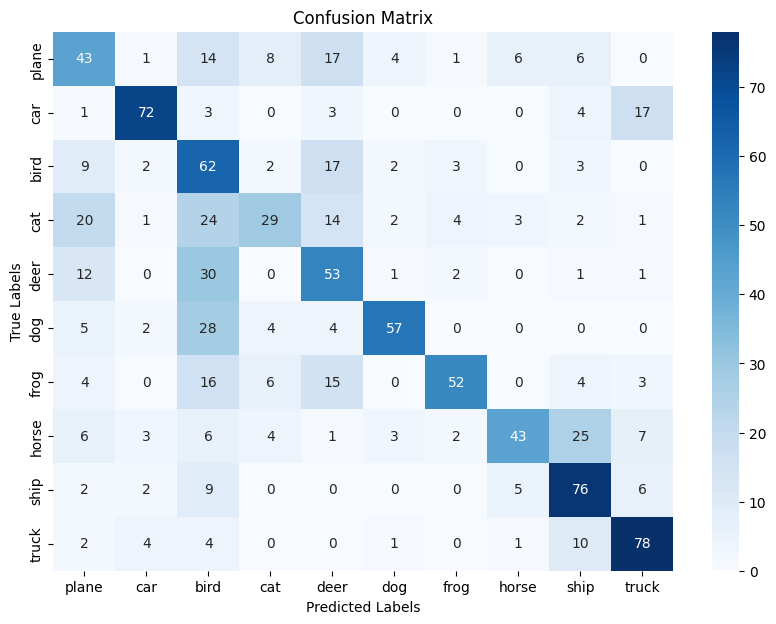

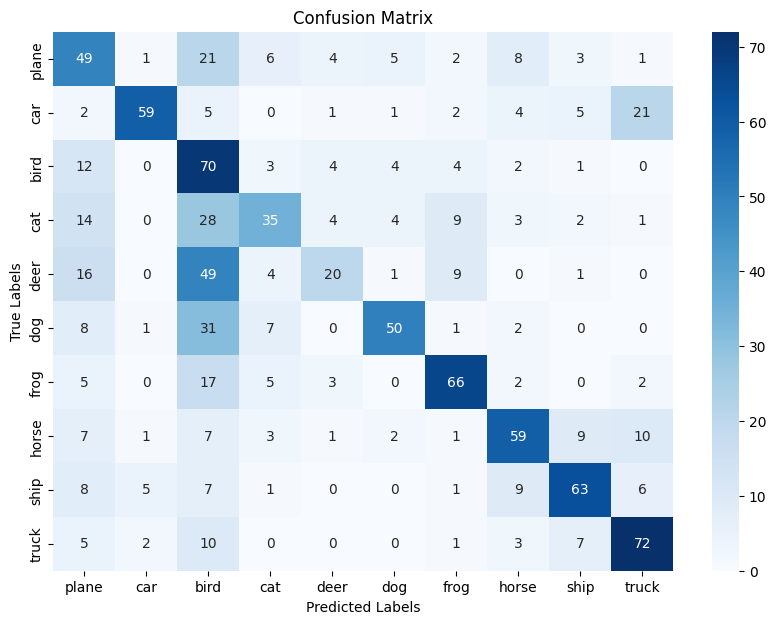

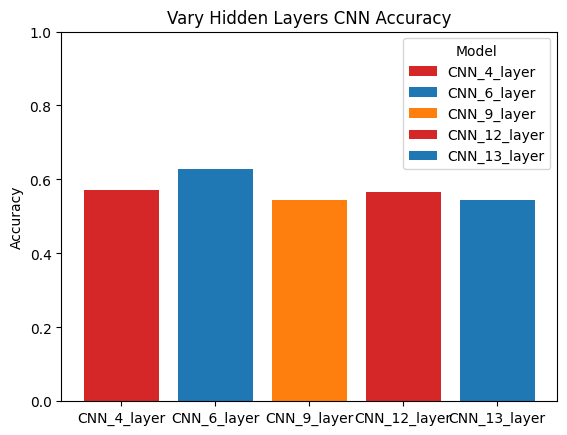

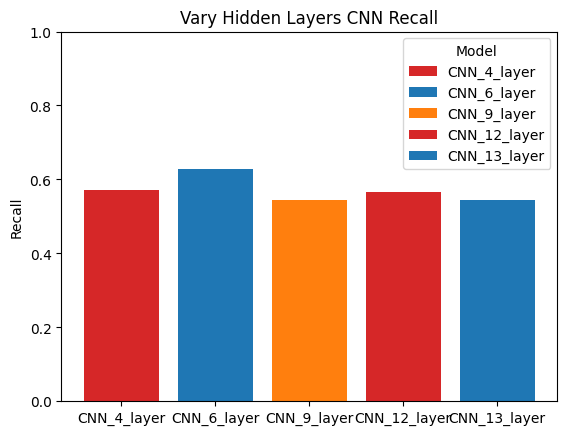

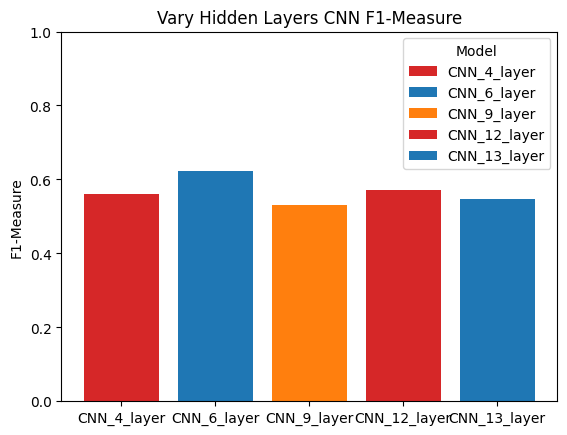

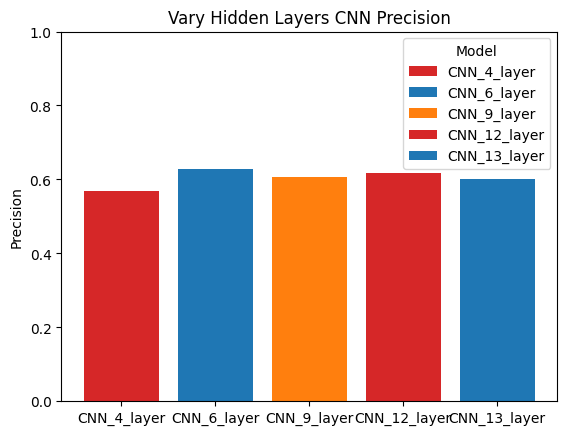

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
diff_layer_cnn_models = [model_4_layers, model_6_layers, model_9_layers, model_12_layers, model_13_layers]
layers = [4, 6, 9, 12, 13]
model_names = []
accuracyArray = []
recallArray = []
precisionArray = []
f1Array =[]
idx = 0
for model in diff_layer_cnn_models:
    currentModel = Dynamic_Layer_CNN(model)
    currentModel = nn.DataParallel(currentModel)
    currentModel.to(device)
    model_name = f'CNN_{layers[idx]}_layer'
    print(model_name)
    idx +=1
    training_losses, trainningAccuracy = [], []
    if os.path.exists(f'./Models/{model_name}.pth'):
        currentModel.load_state_dict(torch.load(f'./Models/{model_name}.pth'))
        
    else:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(currentModel.parameters(), lr = 0.01, momentum=0.9)
        Best_ACC=0
        for epoch in range(CNN_EPOCHS):
            train_loss, train_acc = train(train_loader, currentModel, device, criterion, optimizer, model_name)
            training_losses.append(train_loss)
            trainningAccuracy.append(train_acc)
            if train_acc>Best_ACC:
                Best_ACC=train_acc
                torch.save(currentModel.state_dict(), f'./Models/{model_name}.pth')
        saveTrainLossPlot(training_losses,f'{model_name}', 0.05)
        saveTrainAccuracyPlot(trainningAccuracy,f'{model_name}')
    predictions = predict(test_loader, currentModel, device)
    accuracy, precision, recall, f1 = evaluation(test_labels,predictions,f'{model_name}')
    model_names.append(f'{model_name}')
    accuracyArray.append(accuracy)
    recallArray.append(recall)
    precisionArray.append(precision)
    f1Array.append(f1)
saveAccuracyBarPlot(model_names, accuracyArray, "Vary Hidden Layers CNN Accuracy", "Accuracy")
saveAccuracyBarPlot(model_names, recallArray, "Vary Hidden Layers CNN Recall", "Recall")
saveAccuracyBarPlot(model_names, f1Array, "Vary Hidden Layers CNN F1-Measure", "F1-Measure")
saveAccuracyBarPlot(model_names, precisionArray, "Vary Hidden Layers CNN Precision", "Precision")

#### 3.4.3 Experiment with Different Kernel Sizes for Convolution Network Model

CNN_kernel_2
Training CNN_kernel_2
Training Loss:  0.008614553642272949
Training Accuracy:  19.1
Training CNN_kernel_2
Training Loss:  0.007138879990577698
Training Accuracy:  33.1
Training CNN_kernel_2
Training Loss:  0.006088165473937988
Training Accuracy:  42.559999999999995
Training CNN_kernel_2
Training Loss:  0.005288444185256958
Training Accuracy:  50.739999999999995
Training CNN_kernel_2
Training Loss:  0.004820477533340454
Training Accuracy:  54.779999999999994
Training CNN_kernel_2
Training Loss:  0.004217918801307678
Training Accuracy:  61.1
Training CNN_kernel_2
Training Loss:  0.003287151479721069
Training Accuracy:  69.58
Training CNN_kernel_2
Training Loss:  0.0026046720385551453
Training Accuracy:  76.6
Training CNN_kernel_2
Training Loss:  0.002390736263990402
Training Accuracy:  78.48
Training CNN_kernel_2
Training Loss:  0.002058421230316162
Training Accuracy:  81.6
Training CNN_kernel_2
Training Loss:  0.0014520669758319854
Training Accuracy:  87.08
Training CNN_ker

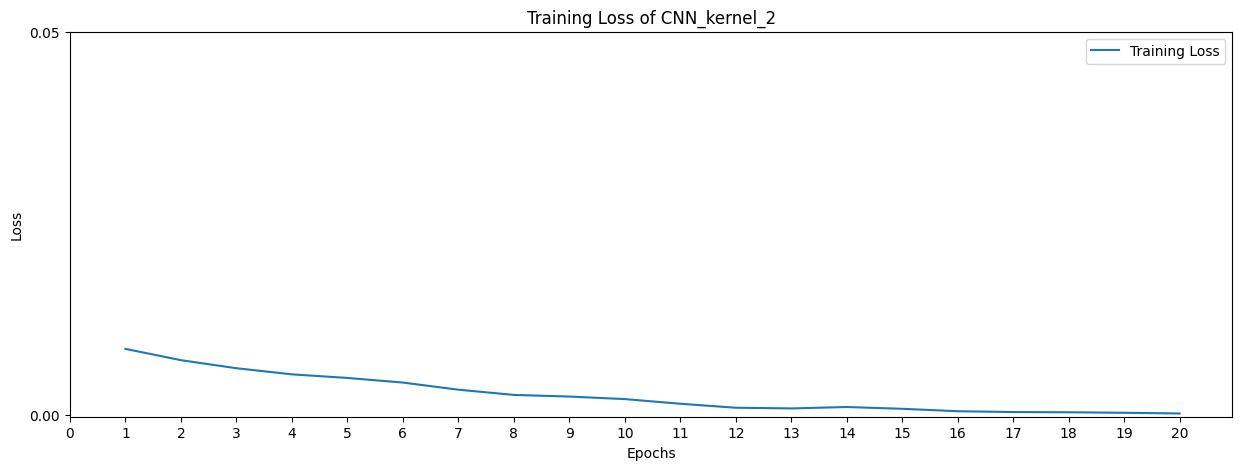

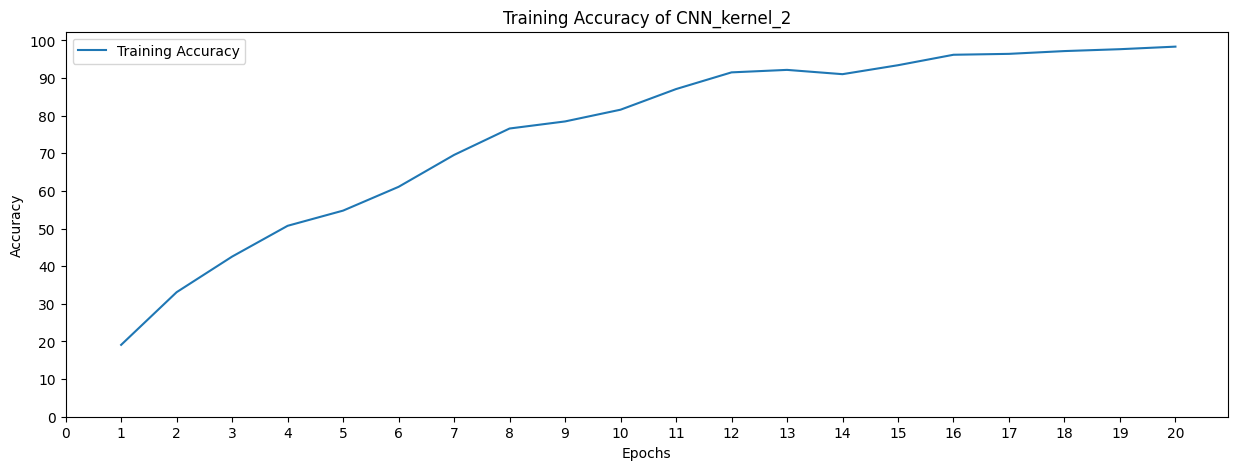

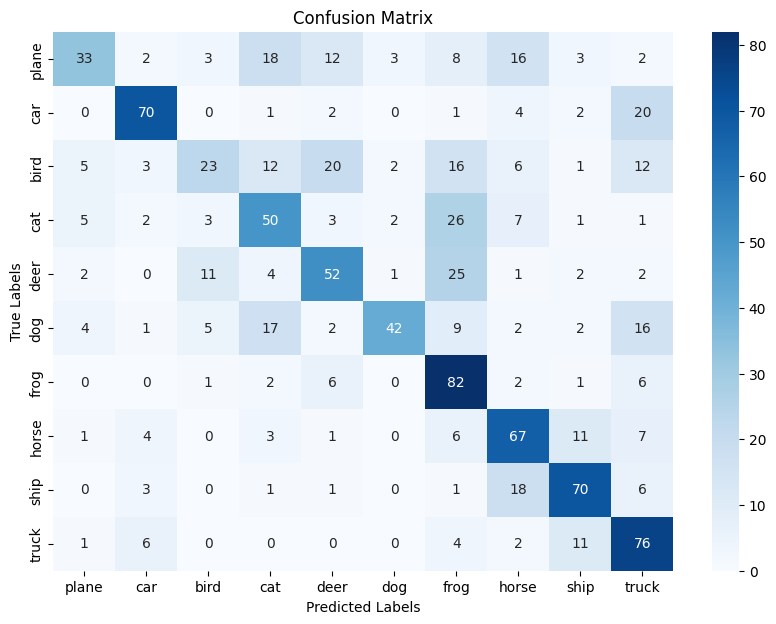

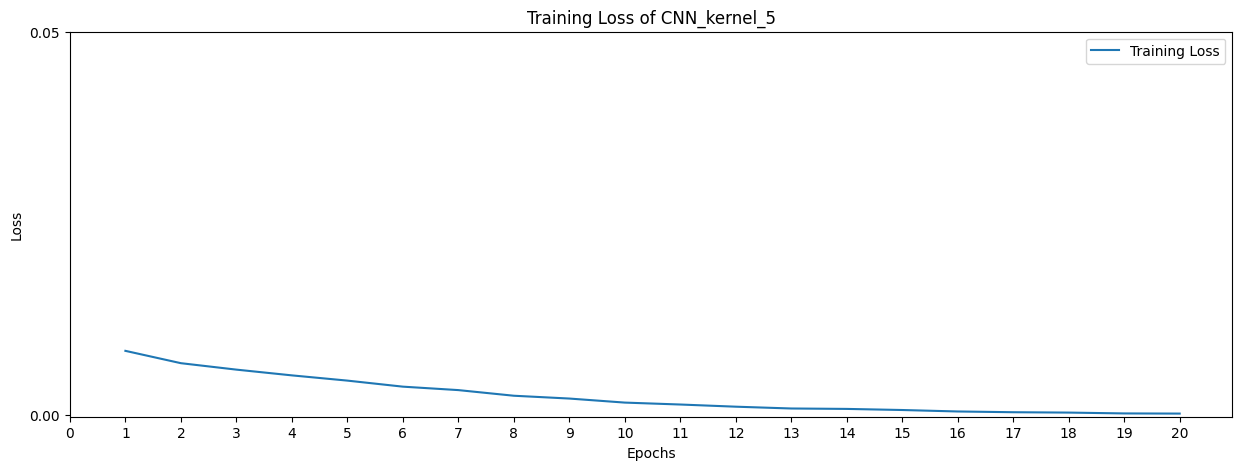

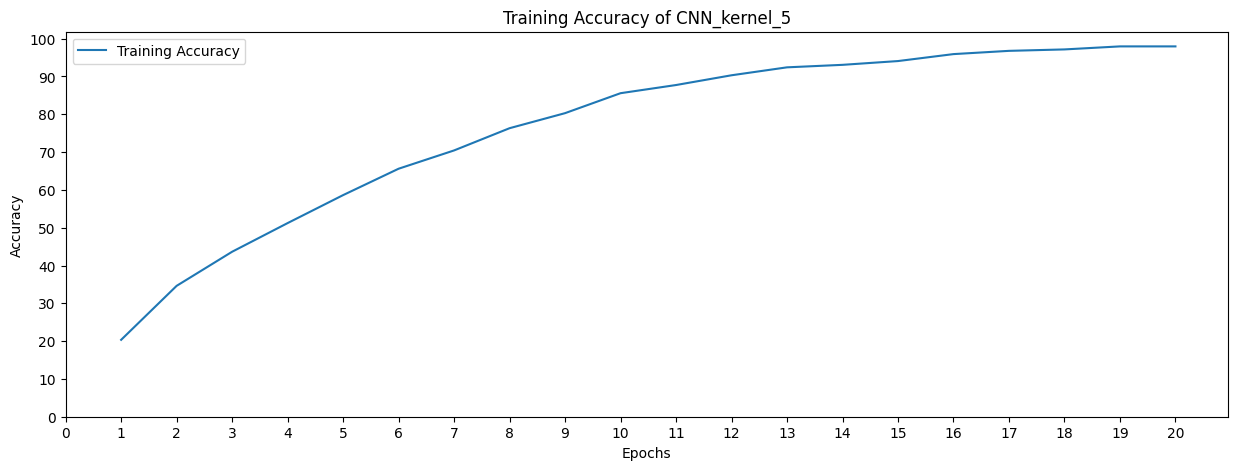

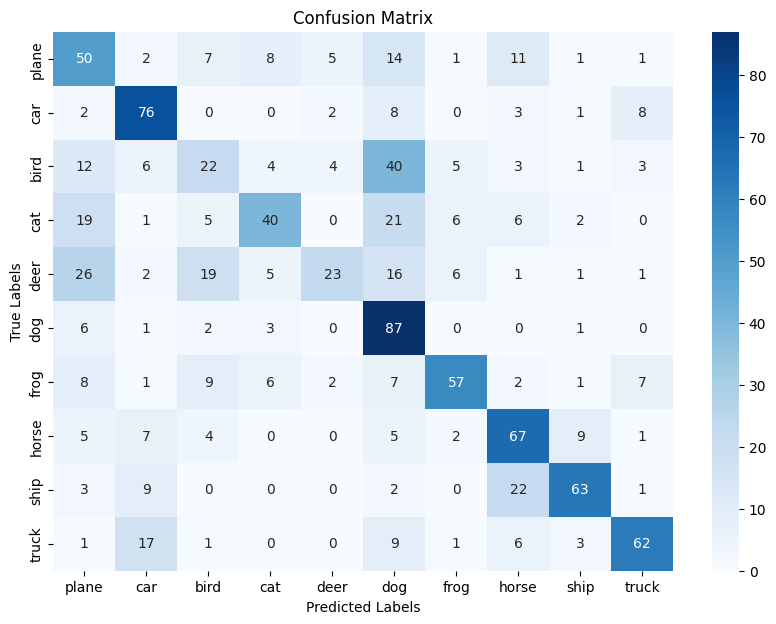

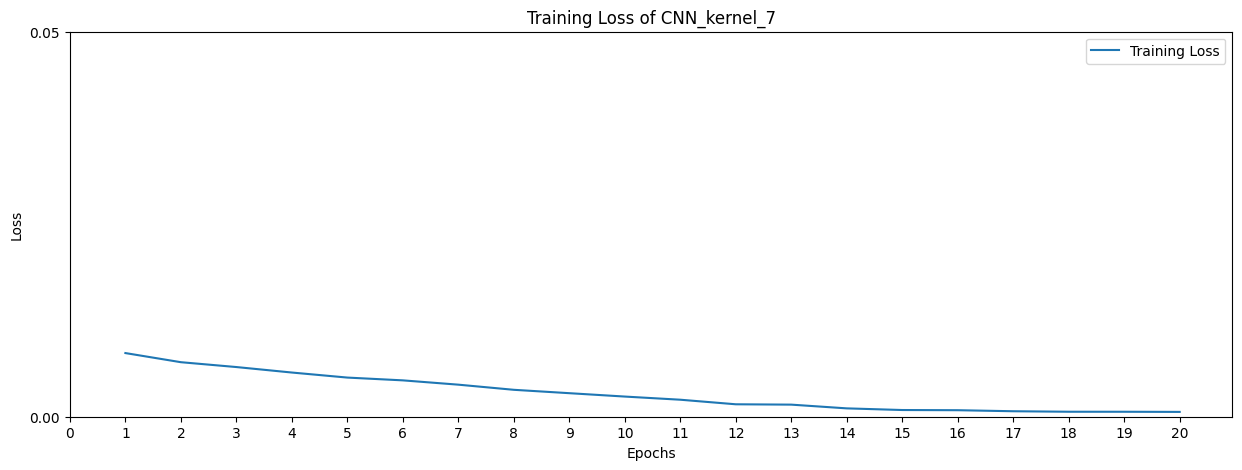

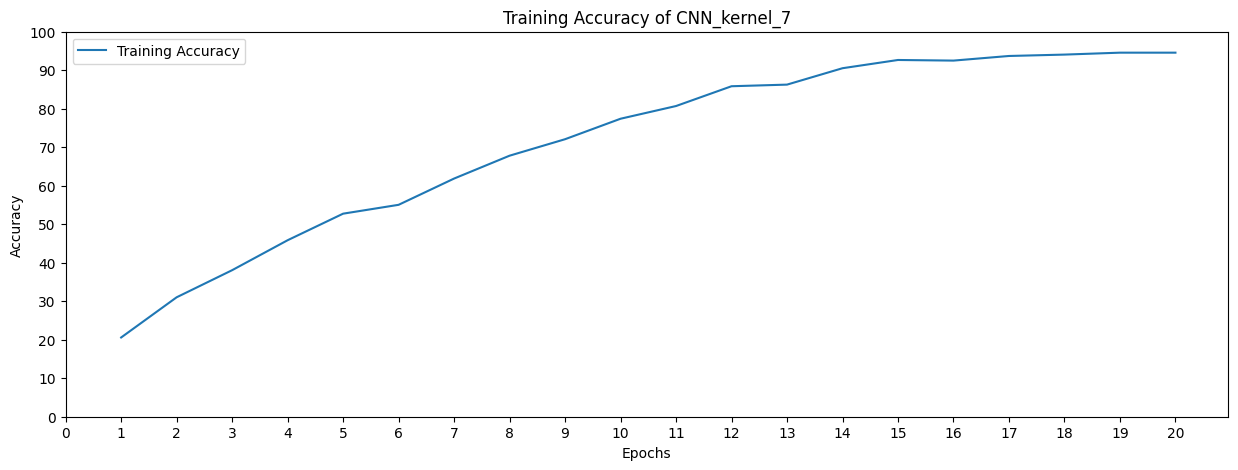

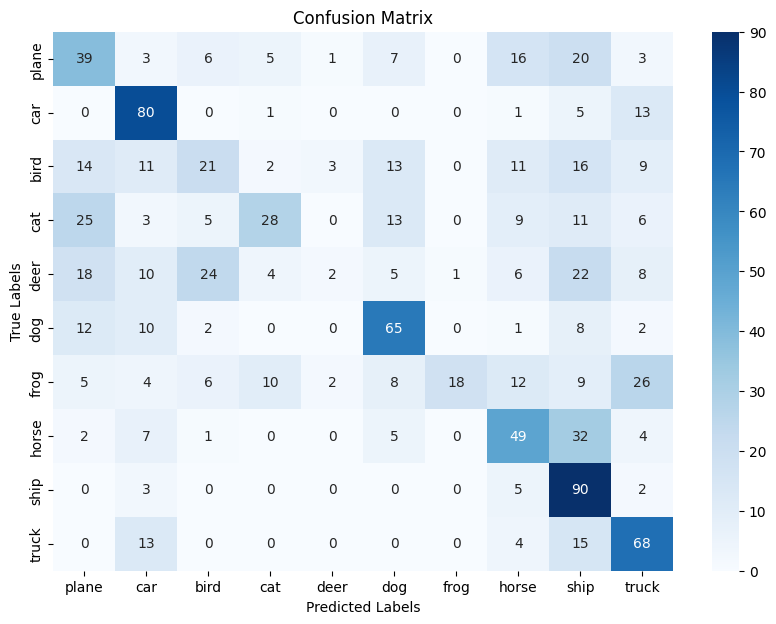

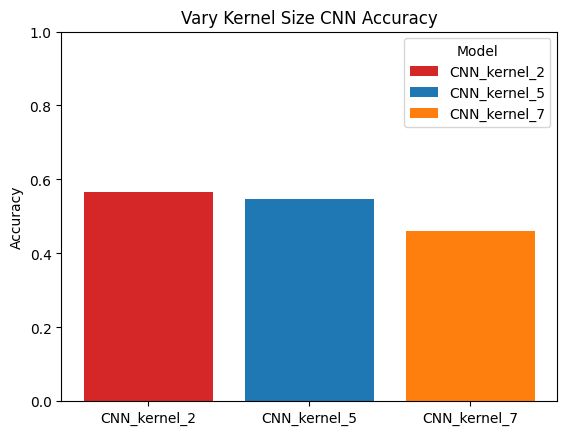

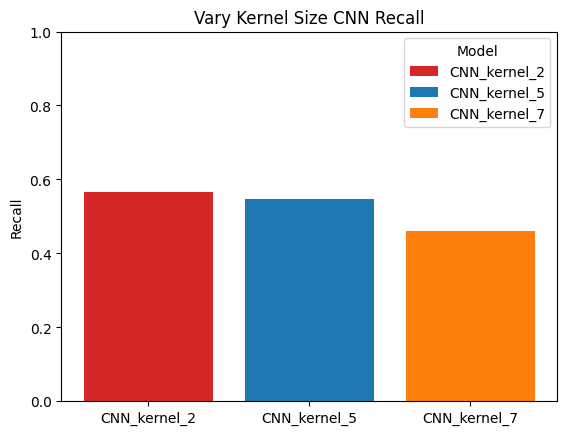

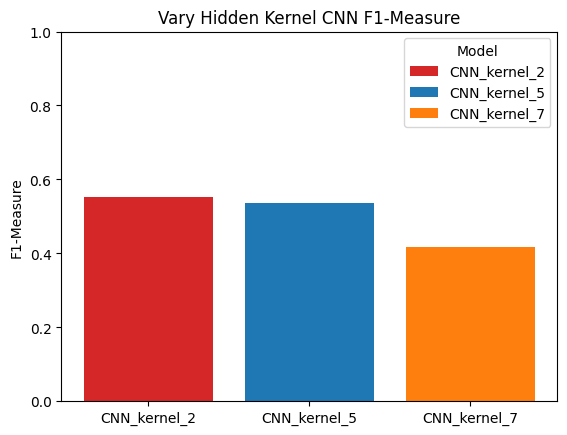

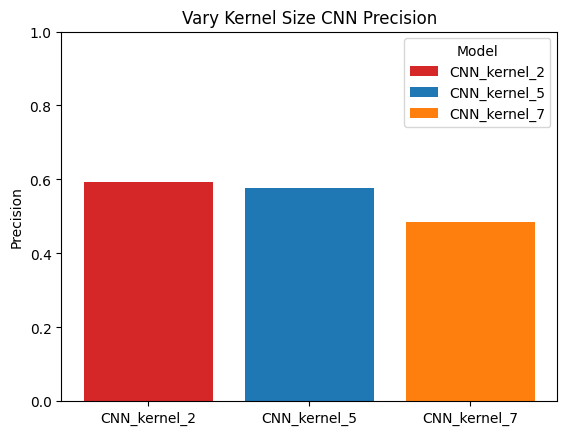

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kernel_sizes = [2, 5, 7]
paddings = [1, 2, 3]
model_names = []
accuracyArray = []
recallArray = []
precisionArray = []
f1Array =[]
idx = 0
for size in kernel_sizes:
    model = CNN(kernel_size=size, padding=paddings[idx])
    idx +=1
    model = nn.DataParallel(model)
    model.to(device)
    model_name = f'CNN_kernel_{size}'
    print(model_name)
    training_losses, trainningAccuracy = [], []
    if os.path.exists(f'./Models/{model_name}.pth'):
        model.load_state_dict(torch.load(f'./Models/{model_name}.pth'))
    else:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
        Best_ACC=0
        for epoch in range(CNN_EPOCHS):
            # Train the model
            train_loss, train_acc = train(train_loader, model, device, criterion, optimizer, model_name)
            training_losses.append(train_loss)
            trainningAccuracy.append(train_acc)
            if train_acc>Best_ACC:
                Best_ACC=train_acc
                torch.save(model.state_dict(), f'./Models/{model_name}.pth')
        saveTrainLossPlot(training_losses,f'{model_name}',0.05)
        saveTrainAccuracyPlot(trainningAccuracy,f'{model_name}')
    # Evaluate the model   
    predictions = predict(test_loader, model, device)
    accuracy, precision, recall, f1 = evaluation(test_labels,predictions,f'{model_name}')
    model_names.append(f'{model_name}')
    accuracyArray.append(accuracy)
    recallArray.append(recall)
    precisionArray.append(precision)
    f1Array.append(f1)
saveAccuracyBarPlot(model_names, accuracyArray, "Vary Kernel Size CNN Accuracy", "Accuracy")
saveAccuracyBarPlot(model_names, recallArray, "Vary Kernel Size CNN Recall", "Recall")
saveAccuracyBarPlot(model_names, f1Array, "Vary Hidden Kernel CNN F1-Measure", "F1-Measure")
saveAccuracyBarPlot(model_names, precisionArray, "Vary Kernel Size CNN Precision", "Precision")

#### 3.4.4 Train CNN model with the entire of CIFAR10 dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = CIFAR10()
train_loader =  torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms), batch_size=CNN_BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms), batch_size=CNN_BATCH_SIZE, shuffle=False)
test_labels = []
for _, label in enumerate(test_loader):
    test_labels += label[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model = CNN()
full_model = nn.DataParallel(full_model)
full_model.to(device)
training_losses, trainningAccuracy = [], []
print(full_model)

if os.path.exists('./Models/CNN_Full.pth'):
    full_model.load_state_dict(torch.load('./Models/CNN_Full.pth'))
    
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(full_model.parameters(), lr = 0.01, momentum=0.9)
    Best_ACC=0
    for epoch in range(CNN_EPOCHS):
        train_loss, train_acc = train(train_loader, full_model, device, criterion, optimizer, 'CNN_Full')
        training_losses.append(train_loss)
        trainningAccuracy.append(train_acc)
        if train_acc>Best_ACC:
            Best_ACC=train_acc
            torch.save(full_model.state_dict(), './Models/CNN_Full.pth')
    saveTrainLossPlot(training_losses,'CNN_Full', 0.005)
    saveTrainAccuracyPlot(trainningAccuracy,'CNN_Full')